# 1. 데이터 불러오는 코드
필요한 심전도 데이터를 불러옵니다.

In [ ]:
# Google Drive Mount

from google.colab import drive

drive.mount("/gdrive", force_remount = True)

In [ ]:
!wget -r -N -c -np https://physionet.org/files/ludb/1.0.0/

Streaming output truncated to the last 5000 lines.
Length: 116 [text/plain]
Saving to: ‘physionet.org/files/ludb/1.0.0/67.atr_v4’

physionet.org/files 100%[===================>]     116  --.-KB/s    in 0s      

2020-12-11 14:53:08 (25.3 MB/s) - ‘physionet.org/files/ludb/1.0.0/67.atr_v4’ saved [116/116]

--2020-12-11 14:53:08--  https://physionet.org/files/ludb/1.0.0/67.atr_v5
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 116 [text/plain]
Saving to: ‘physionet.org/files/ludb/1.0.0/67.atr_v5’

physionet.org/files 100%[===================>]     116  --.-KB/s    in 0s      

2020-12-11 14:53:08 (23.7 MB/s) - ‘physionet.org/files/ludb/1.0.0/67.atr_v5’ saved [116/116]

--2020-12-11 14:53:08--  https://physionet.org/files/ludb/1.0.0/67.atr_v6
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 110 [text/plain]
Saving to: ‘physionet.org/files/ludb/1.0.0/67.atr_v6’

physionet.org/fil

In [ ]:
!pip install wfdb

     |████████████████████████████████| 122kB 5.6MB/s 
     |████████████████████████████████| 6.8MB 18.7MB/s 
     |████████████████████████████████| 163kB 57.6MB/s 
  Created wheel for wfdb: filename=wfdb-3.1.1-cp36-none-any.whl size=117829 sha256=7845f6a191b13d2d10c91da1c1da06c657a7fdda40a370c0ccb1cb9cbaa2e67b
  Stored in directory: /root/.cache/pip/wheels/bc/d0/c1/90538d266ccba2d1076fbc9970192c7ea1a09c99df3e65c69b
Successfully built wfdb


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from pathlib import Path
import re
import wfdb
from wfdb import processing

In [ ]:
data_dir = Path('physionet.org/files/ludb/1.0.0/')

num_records = 200
records = []
for i in range(1,num_records+1):
    record = wfdb.io.rdrecord(f'{data_dir}/{i}')
    age = 99 if record.comments[0][7:] == '>89' else int(record.comments[0][7:])
    data = {'id': i,
            'age(10)' : age //10 * 10, 
            'sex':record.comments[1][-1],
            'dignosis':record.comments[3:]}
    cols = ['i', 'ii',  'iii',  'avr',  'avl',  'avf',  'v1',  'v2',  'v3',  'v4',  'v5',  'v6']
    for col, j in zip(cols, range(12)):
        ann = wfdb.rdann(f'{data_dir}/{i}', f'atr_{col}')
        data[col] = {'singal':record.p_signal[:, j], 'anno': ann.__dict__['symbol'], 'anno_idx': ann.__dict__['sample']}
    records.append(data)

# 2.데이터 전처리 및 시각화
데이터의 형태를 알아 봅니다.

In [ ]:
record_Y_index=[]
record_N_index=[]
Y_list=[]

for i in range(0,len(records)):
  lists_s=records[i]['dignosis']
  if 'Left ventricular hypertrophy.' in lists_s:
    record_Y_index.append(i)
    Y_list.append(1)
  else:
    record_N_index.append(i)
    Y_list.append(0)
print('record_Y_index의 길이는 ',str(len(record_Y_index)))
print('record_N_index의 길이는 ',str(len(record_N_index)))

record_Y_index의 길이는  108
record_N_index의 길이는  92


In [ ]:
yes_records=[]
no_records=[]

for i in record_Y_index:
  yes_records.append(records[i])

for i in record_N_index:
  no_records.append(records[i])

In [ ]:
id_list=[]
age_list=[]
sex_list=[]
for i in range(0,len(records)):
  id_list.append(records[i]['id'])
  age_list.append(records[i]['age(10)'])
  sex_list.append(records[i]['sex'])
d={'id':id_list, 'age(10)':age_list, 'sex':sex_list,'Y':Y_list}
full_id_records=pd.DataFrame(d)
full_id_records['age(10)'] = full_id_records['age(10)'].astype('category')
full_id_records

,id,age(10),sex,Y
0,1,50,F,1
1,2,60,M,1
2,3,50,M,1
3,4,50,M,1
4,5,60,M,0
...,...,...,...,...
195,196,60,F,1
196,197,30,F,0
197,198,30,F,0
198,199,30,F,0


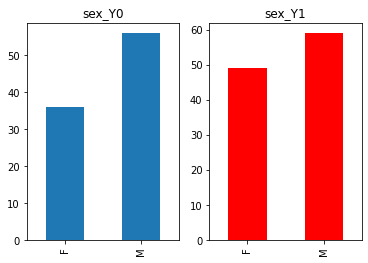

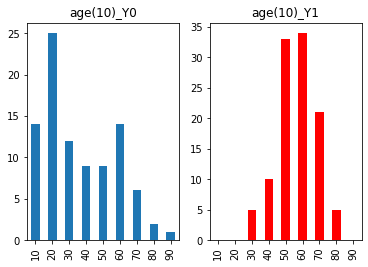

In [ ]:
## y=0 / y=1인 데이터 분포에 대해 sex, age 분포 각각 확인
dat_0=full_id_records[full_id_records['Y']==0]
dat_1=full_id_records[full_id_records['Y']==1]
for categorical_feature in ['sex','age(10)']:
    plt.subplot(1,2,1)
    dat_0[categorical_feature].value_counts().sort_index().plot(kind="bar").set_title(categorical_feature+'_Y0')
    plt.subplot(1,2,2)
    dat_1[categorical_feature].value_counts().sort_index().plot(kind="bar",color='red').set_title(categorical_feature+'_Y1')
    plt.show()

In [ ]:
def dataframe_for_signal(records,signal_cat):
  datafr=pd.DataFrame()
  columnlen=len(records)
  for i in range(0,columnlen):
    sub_list=records[i][signal_cat]['singal']
    column_name='record_'+str(i)
    df = pd.DataFrame (sub_list,columns=[column_name])
    datafr = pd.concat([datafr, df], axis=1)
  return datafr

In [ ]:
#### 각 유도에 대한 전체 record signal dataframe

i_df=dataframe_for_signal(records,'i')
ii_df=dataframe_for_signal(records,'ii')
iii_df=dataframe_for_signal(records,'iii')
avr_df=dataframe_for_signal(records,'avr')
avl_df=dataframe_for_signal(records,'avl')
avf_df=dataframe_for_signal(records,'avf')
v1_df=dataframe_for_signal(records,'v1')
v2_df=dataframe_for_signal(records,'v2')
v3_df=dataframe_for_signal(records,'v3')
v4_df=dataframe_for_signal(records,'v4')
v5_df=dataframe_for_signal(records,'v5')
v6_df=dataframe_for_signal(records,'v6')

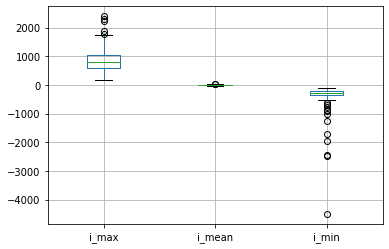

In [ ]:
mean=i_df.apply(np.mean, axis=0)
min=i_df.apply(np.min, axis=0)
max=i_df.apply(np.max, axis=0)
df_i={ 'i_max':max,'i_mean':mean,'i_min':min}
df_i_look=pd.DataFrame(df_i)
df_i_look.plot.box(grid='True')

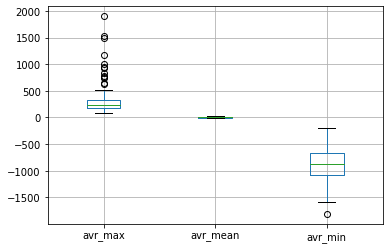

In [ ]:
mean=avr_df.apply(np.mean, axis=0)
min=avr_df.apply(np.min, axis=0)
max=avr_df.apply(np.max, axis=0)
df_avr={ 'avr_max':max,'avr_mean':mean,'avr_min':min}
df_avr_look=pd.DataFrame(df_avr)
df_avr_look.plot.box(grid='True')

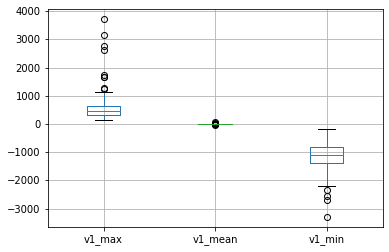

In [ ]:
mean=v1_df.apply(np.mean, axis=0)
min=v1_df.apply(np.min, axis=0)
max=v1_df.apply(np.max, axis=0)
df_v1={ 'v1_max':max,'v1_mean':mean,'v1_min':min}
df_v1_look=pd.DataFrame(df_v1)
df_v1_look.plot.box(grid='True')

No handles with labels found to put in legend.


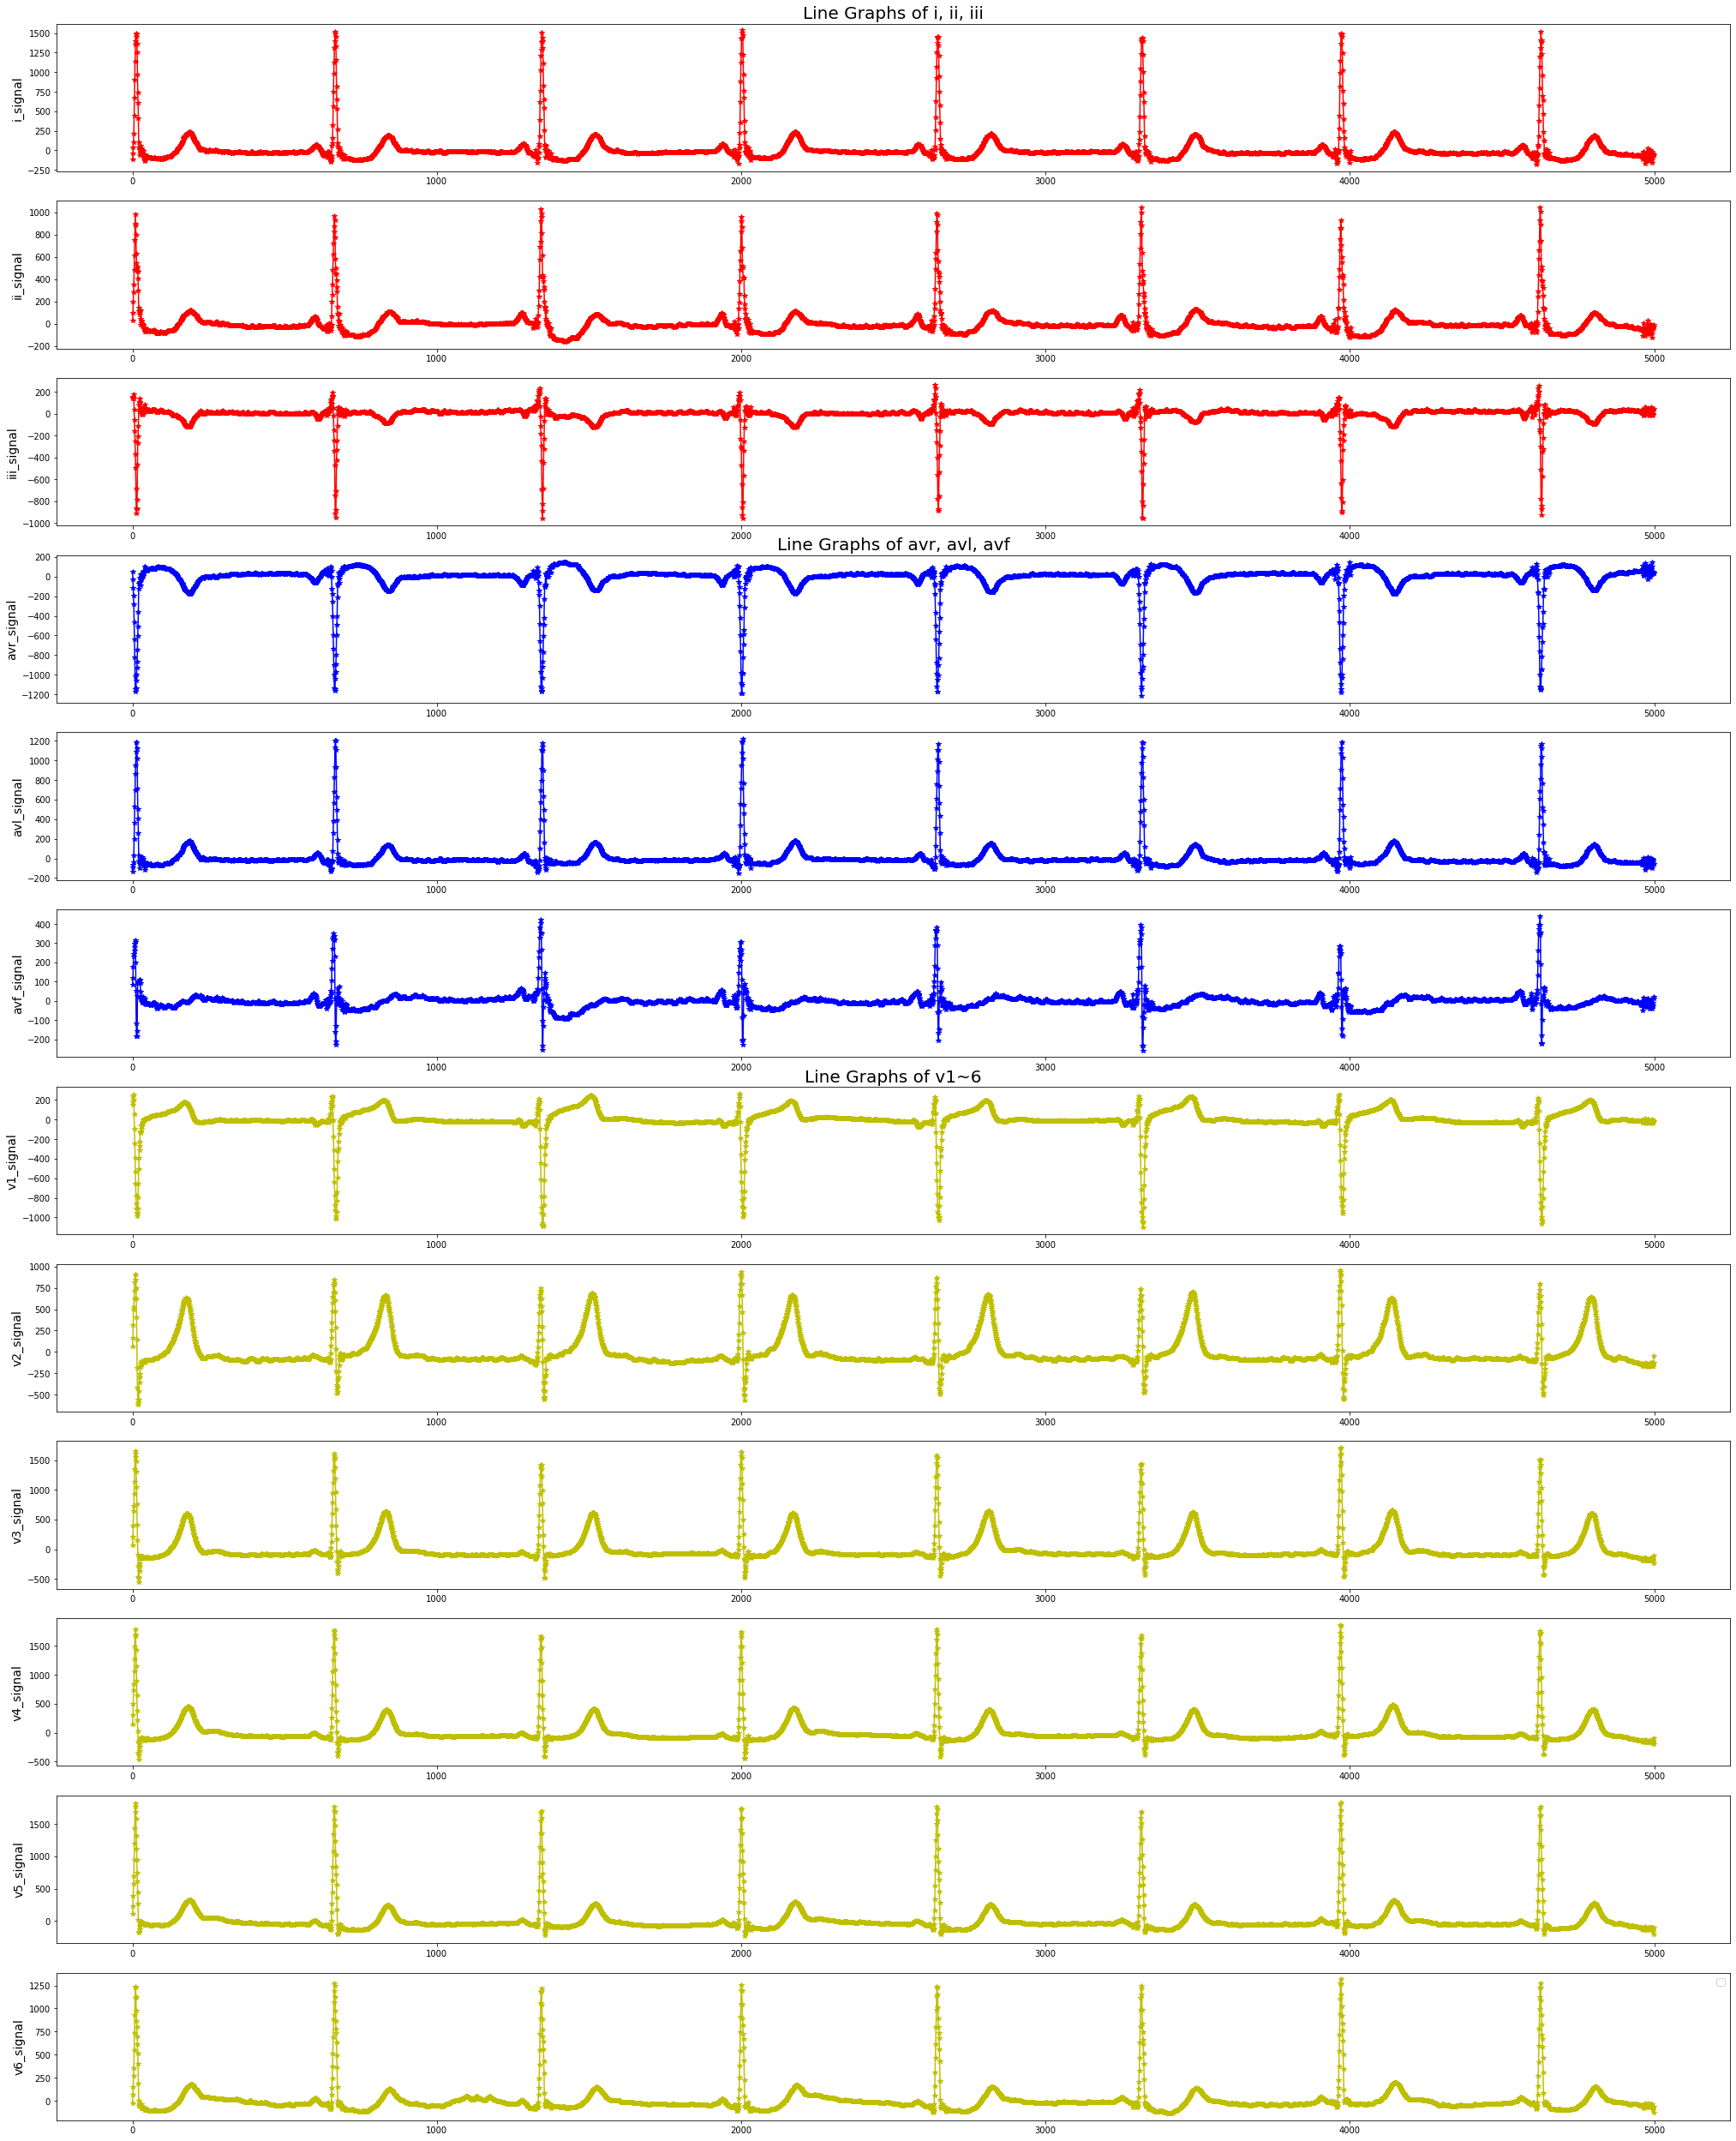

In [ ]:
import matplotlib.pyplot as plt
## Y=1인 record 첫번째 환자의 signal
# Line Graph by matplotlib with wide-form DataFrame
plt.figure(figsize=(35, 45))
plt.subplot(12,1,1)
plt.title('Line Graphs of i, ii, iii', fontsize=20) 
plt.plot(i_df.index, i_df.record_0, marker='*', color='r')
plt.ylabel('i_signal', fontsize=14)
plt.subplot(12,1,2)
plt.plot(ii_df.index, ii_df.record_0, marker='*', color='r')
plt.ylabel('ii_signal', fontsize=14)
plt.subplot(12,1,3)
plt.plot(iii_df.index, iii_df.record_0, marker='*', color='r')
plt.ylabel('iii_signal', fontsize=14)

plt.subplot(12,1,4)
plt.title('Line Graphs of avr, avl, avf', fontsize=20) 
plt.plot(avr_df.index,avr_df.record_0, marker='*', color='b')
plt.ylabel('avr_signal', fontsize=14)
plt.subplot(12,1,5)
plt.plot(avl_df.index, avl_df.record_0, marker='*', color='b')
plt.ylabel('avl_signal', fontsize=14)
plt.subplot(12,1,6)
plt.plot(avf_df.index, avf_df.record_0, marker='*', color='b')
plt.ylabel('avf_signal', fontsize=14)

plt.subplot(12,1,7)
plt.title('Line Graphs of v1~6', fontsize=20) 
plt.plot(v1_df.index,v1_df.record_0, marker='*', color='y')
plt.ylabel('v1_signal', fontsize=14)
plt.subplot(12,1,8)
plt.plot(v2_df.index, v2_df.record_0, marker='*', color='y')
plt.ylabel('v2_signal', fontsize=14)
plt.subplot(12,1,9)
plt.plot(v3_df.index, v3_df.record_0, marker='*', color='y')
plt.ylabel('v3_signal', fontsize=14)
plt.subplot(12,1,10)
plt.plot(v4_df.index,v4_df.record_0, marker='*', color='y')
plt.ylabel('v4_signal', fontsize=14)
plt.subplot(12,1,11)
plt.plot(v5_df.index, v5_df.record_0, marker='*', color='y')
plt.ylabel('v5_signal', fontsize=14)
plt.subplot(12,1,12)
plt.plot(v6_df.index,v6_df.record_0, marker='*', color='y')
plt.ylabel('v6_signal', fontsize=14)


#plt.plot(wide_df.index, wide_df.c, marker='*', color='b')
#plt.plot(wide_df.index, wide_df.d, marker='*', color='y')



#plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=12, loc='best')
plt.show()

In [ ]:
### scaled_dat에 min max scaling 함 ###

from sklearn.preprocessing import minmax_scale
import copy

keys_r=list(records[0].keys())
udo_list=keys_r[4:]
keys_sec=['singal', 'anno', 'anno_idx']
scaled_dat=copy.deepcopy(records)

for i in udo_list:
  for j in range(0,len(records)):
      lists_s=records[j][i]['singal']
      scaled_ = minmax_scale(lists_s)
      scaled_dat[j][i]['singal']=scaled_
      #print(i,j,np.mean(scaled_dat[j][i]['singal']))

In [ ]:
### 각 유도에 대한 전체 record signal dataframe ###

i_df=dataframe_for_signal(scaled_dat,'i')
ii_df=dataframe_for_signal(scaled_dat,'ii')
iii_df=dataframe_for_signal(scaled_dat,'iii')
avr_df=dataframe_for_signal(scaled_dat,'avr')
avl_df=dataframe_for_signal(scaled_dat,'avl')
avf_df=dataframe_for_signal(scaled_dat,'avf')
v1_df=dataframe_for_signal(scaled_dat,'v1')
v2_df=dataframe_for_signal(scaled_dat,'v2')
v3_df=dataframe_for_signal(scaled_dat,'v3')
v4_df=dataframe_for_signal(scaled_dat,'v4')
v5_df=dataframe_for_signal(scaled_dat,'v5')
v6_df=dataframe_for_signal(scaled_dat,'v6')

No handles with labels found to put in legend.


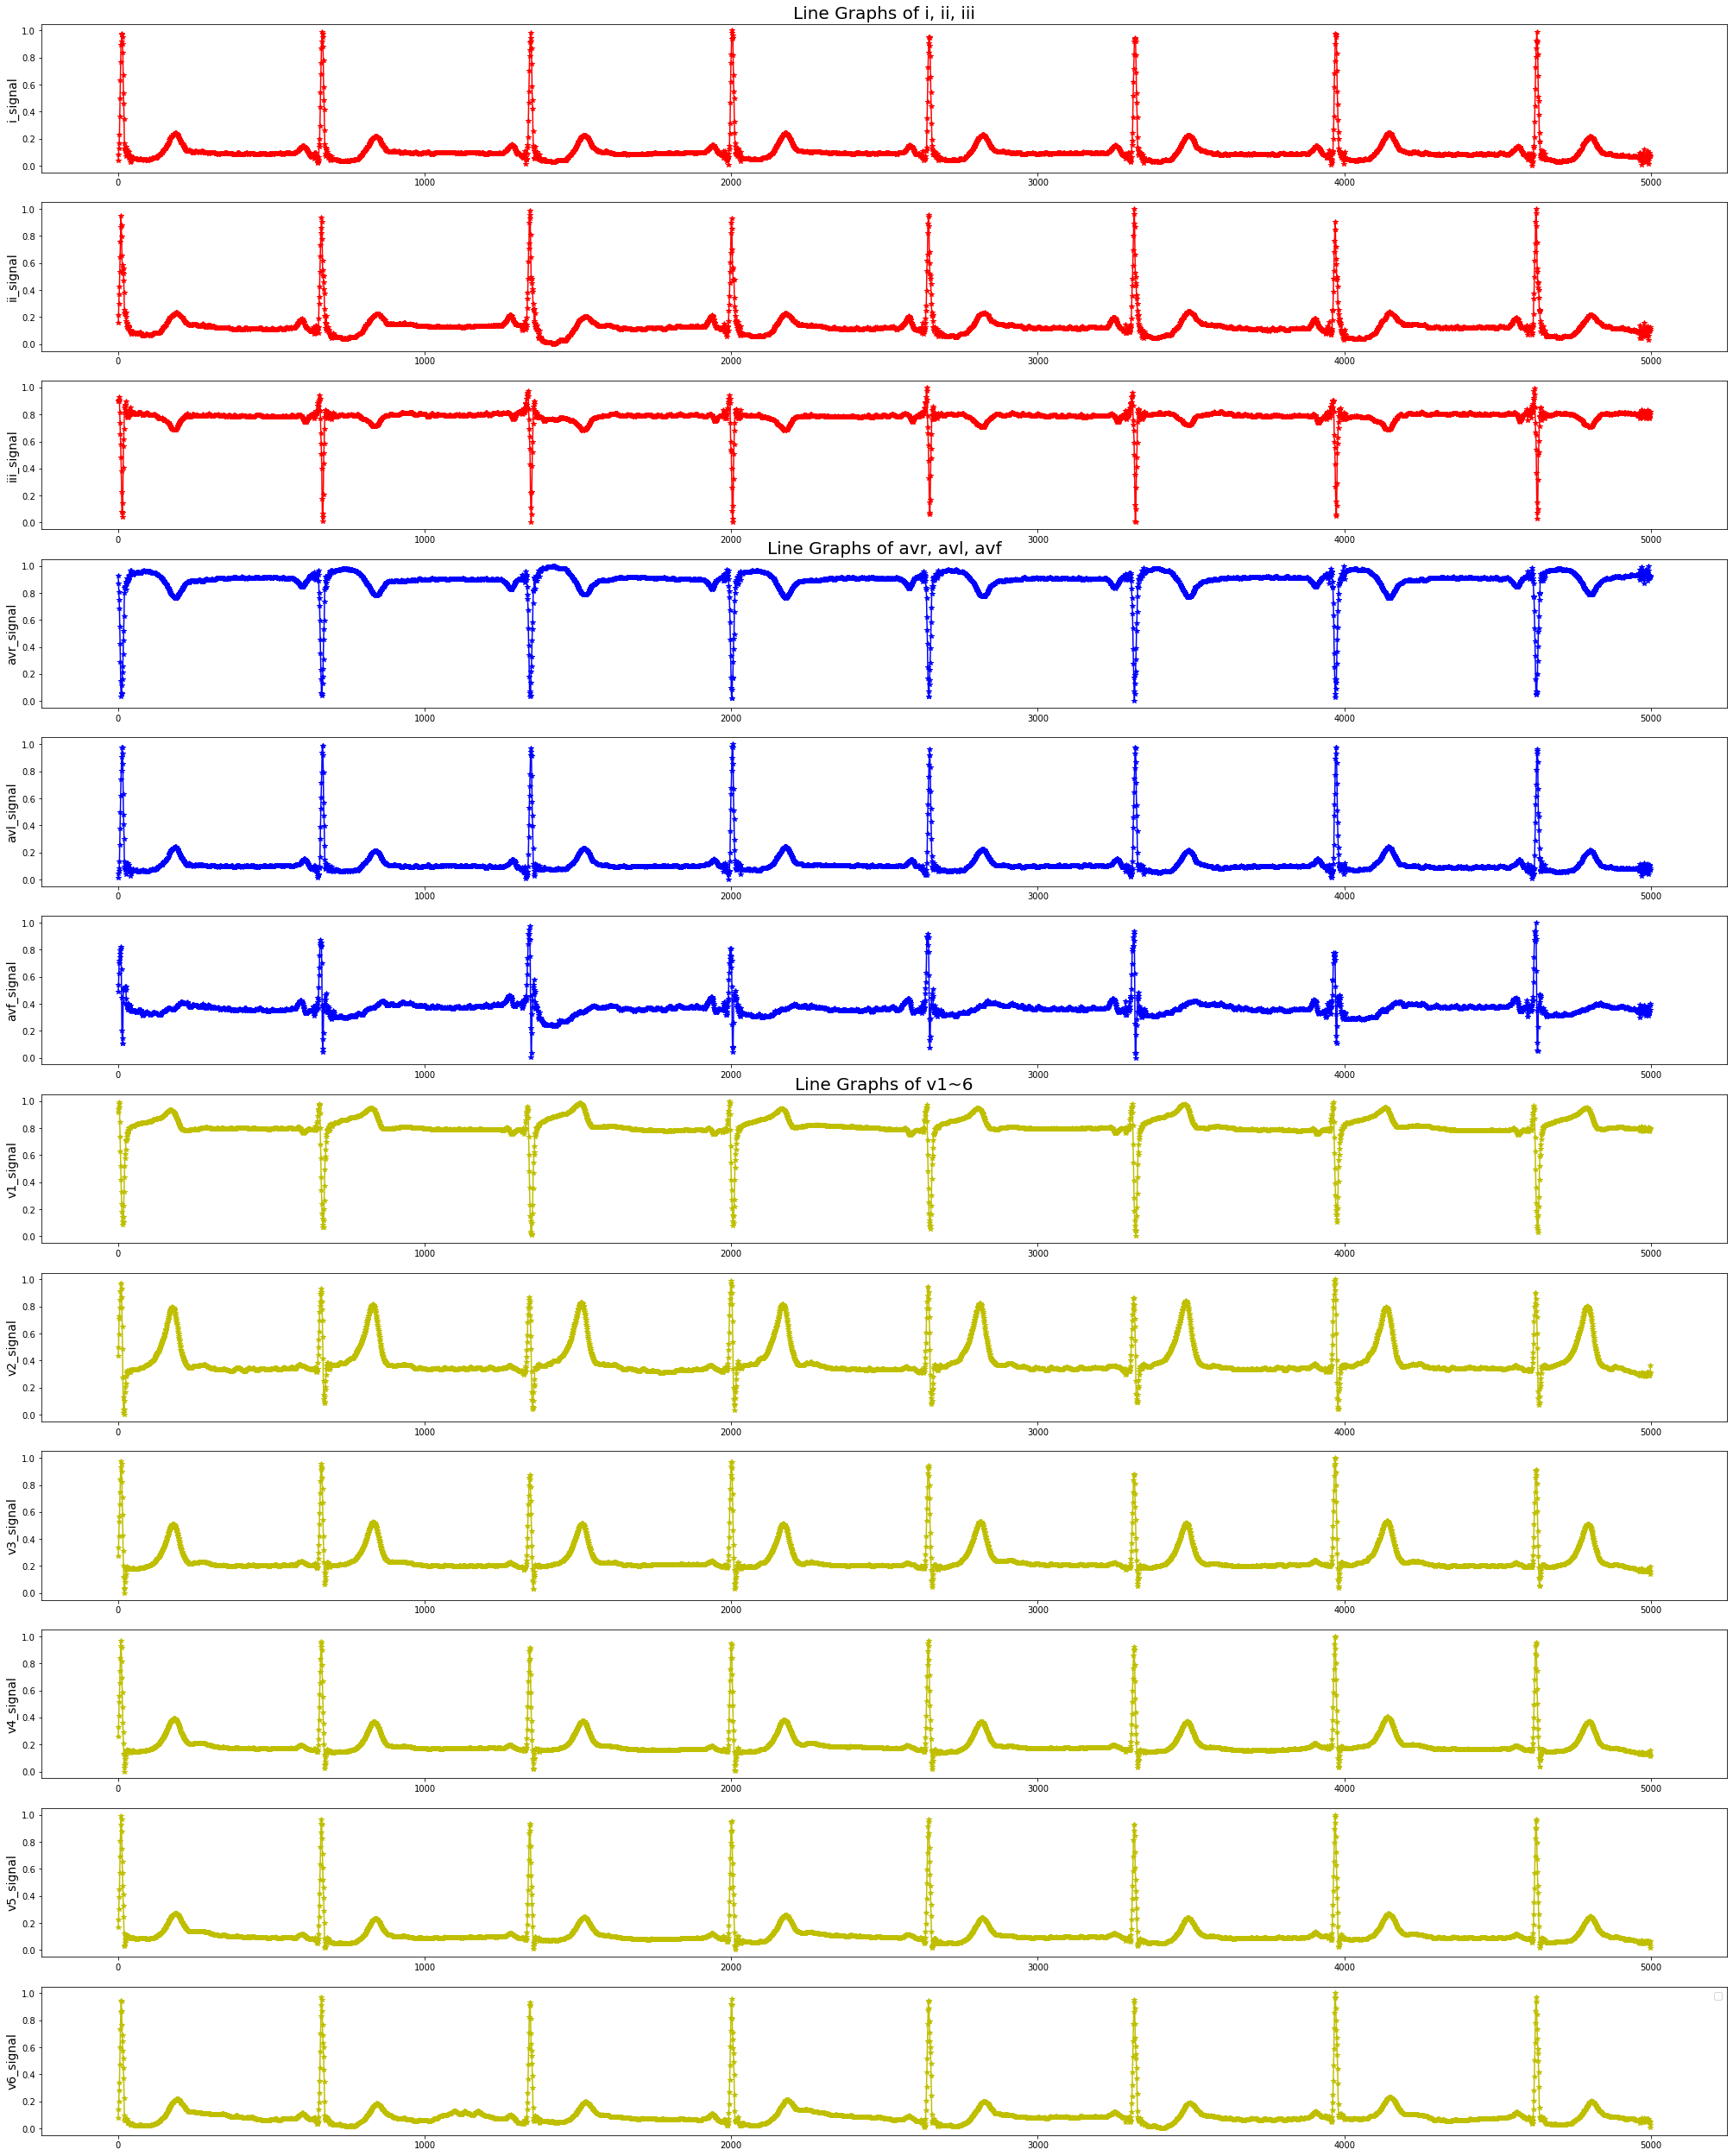

In [ ]:
import matplotlib.pyplot as plt
## Y=1인 record 첫번째 환자의 signal
# Line Graph by matplotlib with wide-form DataFrame
plt.figure(figsize=(35, 45))
plt.subplot(12,1,1)
plt.title('Line Graphs of i, ii, iii', fontsize=20) 
plt.plot(i_df.index, i_df.record_0, marker='*', color='r')
plt.ylabel('i_signal', fontsize=14)
plt.subplot(12,1,2)
plt.plot(ii_df.index, ii_df.record_0, marker='*', color='r')
plt.ylabel('ii_signal', fontsize=14)
plt.subplot(12,1,3)
plt.plot(iii_df.index, iii_df.record_0, marker='*', color='r')
plt.ylabel('iii_signal', fontsize=14)

plt.subplot(12,1,4)
plt.title('Line Graphs of avr, avl, avf', fontsize=20) 
plt.plot(avr_df.index,avr_df.record_0, marker='*', color='b')
plt.ylabel('avr_signal', fontsize=14)
plt.subplot(12,1,5)
plt.plot(avl_df.index, avl_df.record_0, marker='*', color='b')
plt.ylabel('avl_signal', fontsize=14)
plt.subplot(12,1,6)
plt.plot(avf_df.index, avf_df.record_0, marker='*', color='b')
plt.ylabel('avf_signal', fontsize=14)

plt.subplot(12,1,7)
plt.title('Line Graphs of v1~6', fontsize=20) 
plt.plot(v1_df.index,v1_df.record_0, marker='*', color='y')
plt.ylabel('v1_signal', fontsize=14)
plt.subplot(12,1,8)
plt.plot(v2_df.index, v2_df.record_0, marker='*', color='y')
plt.ylabel('v2_signal', fontsize=14)
plt.subplot(12,1,9)
plt.plot(v3_df.index, v3_df.record_0, marker='*', color='y')
plt.ylabel('v3_signal', fontsize=14)
plt.subplot(12,1,10)
plt.plot(v4_df.index,v4_df.record_0, marker='*', color='y')
plt.ylabel('v4_signal', fontsize=14)
plt.subplot(12,1,11)
plt.plot(v5_df.index, v5_df.record_0, marker='*', color='y')
plt.ylabel('v5_signal', fontsize=14)
plt.subplot(12,1,12)
plt.plot(v6_df.index,v6_df.record_0, marker='*', color='y')
plt.ylabel('v6_signal', fontsize=14)


#plt.plot(wide_df.index, wide_df.c, marker='*', color='b')
#plt.plot(wide_df.index, wide_df.d, marker='*', color='y')



#plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=12, loc='best')
plt.show()

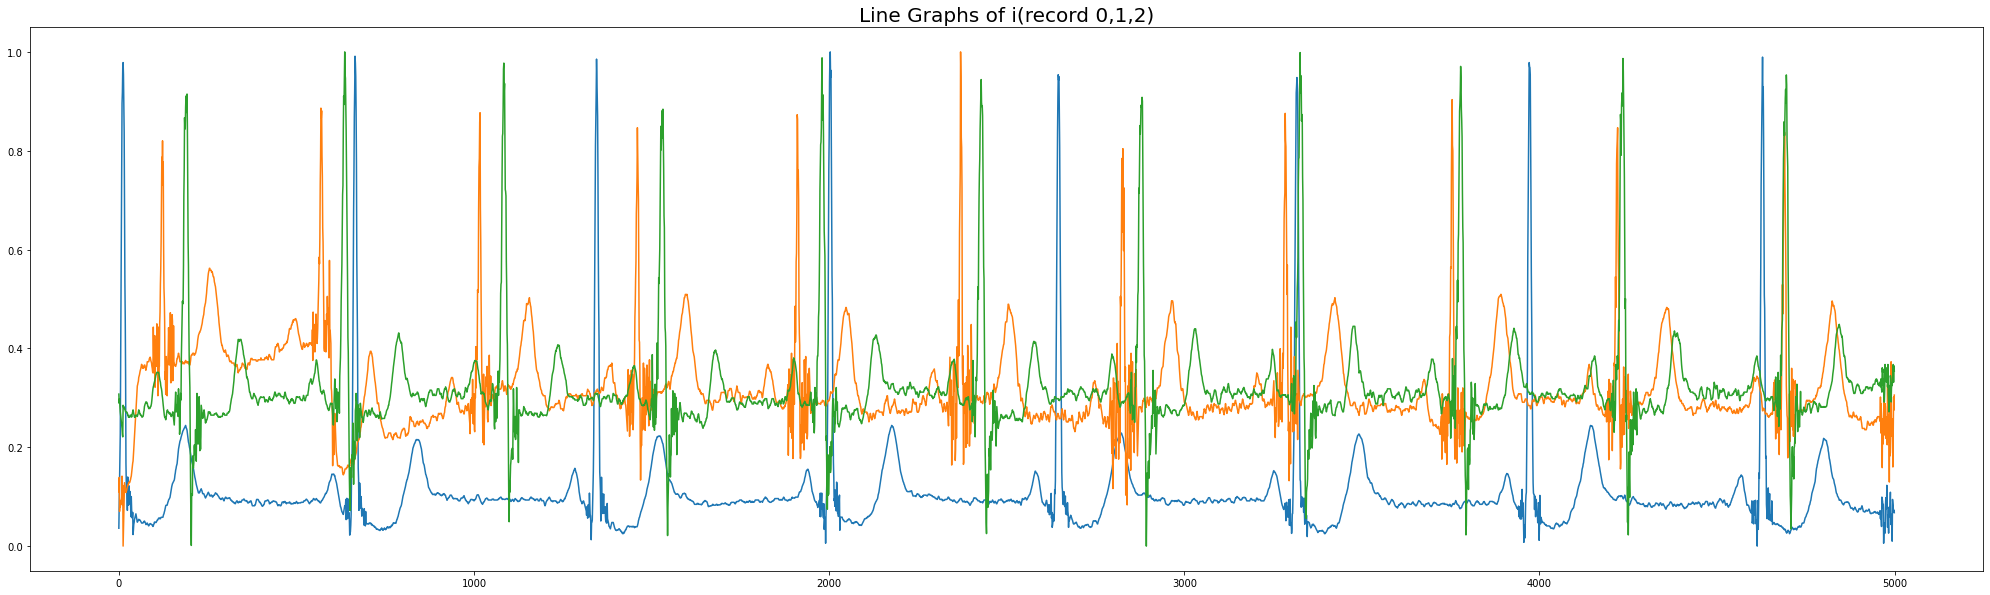

In [ ]:
plt.figure(figsize=(35, 10))
plt.title('Line Graphs of i(record 0,1,2)', fontsize=20) 
plt.plot(i_df['record_0'])
plt.plot(i_df['record_1'])
plt.plot(i_df['record_2'])
plt.show()

## Anno 활용 데이터 전처리

In [ ]:
###anno 값 string 형태로 바꾸기 ###
for i in udo_list:
  for j in range(0,len(scaled_dat)):
      lists_s=scaled_dat[j][i]['anno']
      scaled_dat[j][i]['anno']=''.join(lists_s)
      #print(str(j),'번째 record의 ',str(i),'anno,anno_idx 중 ',str(k), ' 의 리스트')
      #print('리스트의 길이 ',str(len(lists_s)),'string 길이',str(len(scaled_dat[j][i]['anno'])))

(N)(t)(p)(N)(t)(p)(N)(t)(p)(N)(t)(p)(N)(t)(p)(N)
[-47.00002445602029, 1245.0115276786566, -24.989606191375028, -117.01094073416972, 126.99344356328662, -22.010418264645264, -39.99670955363316, 3.001420672451627, -79.99341910726632, -89.99815468210508, 1219.9996887415598, -10.004735574838756, -52.002392243439665, 145.00196759799638, 2.0009471149677514, -41.99765666860091, 20.009471149677513, -68.00996916318168, -70.01091627814942, 1254.9940305077737, -18.00852403470976, -76.99199843481469, 169.9915737893714, 62.00712781827843, -47.00002445602029, -8.003788459871005, -62.00712781827843, -60.006180703310676, 1230.0044243163986, -41.99765666860091, -89.99815468210508, 147.00291471296413, 17.008050477225886, -7.003314902387129, 34.994341766213786, -13.006156247290383, -27.991026863826654, 1243.010580563689, -24.989606191375028, -112.00857294675035, 132.99628490818986, 0.0, -24.989606191375028, 39.99670955363316, -22.010418264645264, -7.003314902387129, 1317.001158326052, 20.009471149677513]

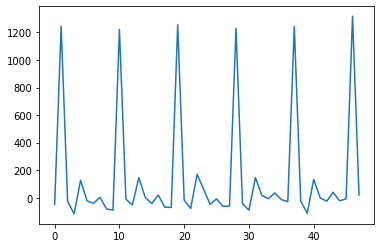

In [ ]:
### 정상적인 Ntp ###
lists_s=records[0]['v6']['anno']
lists_s
a=''.join(lists_s)
print(a)

signal_avl_0=records[0]['v6']['singal']
annoidx_avl_0=records[0]['v6']['anno_idx']


signal_bw=[]

for i in annoidx_avl_0:
  signal_bw.append(signal_avl_0[i+1])


print(signal_bw)
plt.plot(signal_bw)

(N)(t)(p)(N)(t)(p)(N)(t)(p)(N)(t)(p)(N)(t)(p)(N)(t)(p)(N)(t)(p)(N)
[-52.012215812690876, 618.0115371564303, -40.01357312521208, 25.00169664065151, 327.0037326094333, -20.00678656260604, -80.0, -40.01357312521208, -91.99864268747879, -95.01187648456057, 585.0016966406515, -62.00203596878181, -2.0088225313878523, 379.993213437394, 9.989820156090941, -40.01357312521208, 29.99660671869698, -64.98812351543943, -59.99321343739396, 587.9877841873091, -88.00814387512725, -4.9949100780454705, 317.99117746861214, -29.99660671869698, -101.98846284356974, 88.00814387512725, -9.989820156090941, 2.0088225313878523, 653.0030539531728, 0.0, 63.00644723447574, 386.9969460468273, 34.99151679674245, -40.01357312521208, 34.99151679674245, -37.0003393281303, -45.008483203257555, 623.0064472344758, -58.01153715643027, 7.003732609433322, 345.0016966406515, -13.003053953172719, -70.01017984390906, -9.989820156090941, -139.99321343739396, -167.00373260943334, 520.0135731252121, -71.99185612487275, 15.011876484

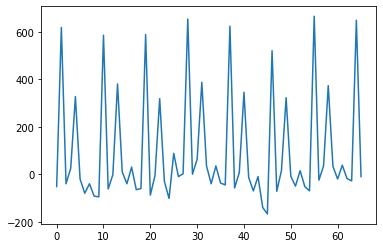

In [ ]:
### 정상적인 Ntp ###
lists_s=records[198]['v2']['anno']
lists_s
a=''.join(lists_s)
print(a)

signal_avl_0=records[198]['v2']['singal']
annoidx_avl_0=records[198]['v2']['anno_idx']


signal_bw=[]

for i in annoidx_avl_0:
  signal_bw.append(signal_avl_0[i+1])


print(signal_bw)
plt.plot(signal_bw)

N)(t)N)(t)N)(t)N)(t)N)(t)N)(t)N)(t)N)(t)N)
[534.997723357289, -95.00656365413137, -7.00300623347437, 81.00055118718262, -79.0034961776367, 680.0105444504503, -48.99441623419331, -16.00306747649466, 100.01251487805982, -39.009141186463694, 574.9920783484621, -25.003128719514955, 37.01208617691777, 102.99478369231505, -21.00901870042311, 594.9892558440486, -5.005951223928447, 57.009263672504275, 122.99196118790157, 0.0, 495.0033683661161, -5.005951223928447, 54.00036745812175, 122.99196118790157, -18.000122486040585, 615.0130607397624, 5.005951223928447, 59.0063186820502, 104.99183870186098, 1.9970550095459227, 594.9892558440486, 28.01202493389748, 84.99466120627447, 124.98901619744748, 41.991410000718936, 700.0077219460369, 79.0034961776367, 122.00674738319225, 199.99840235599234, 79.98870998234602, 920.0033017976157, 138.0098148596869]


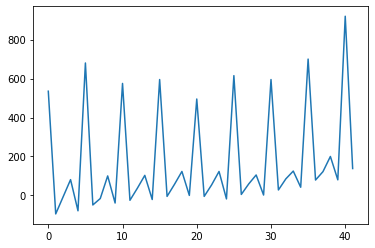

In [ ]:
### 이상한 개체 1 ###
lists_s=records[103]['ii']['anno']
lists_s
a=''.join(lists_s)
print(a)

signal_avl_0=records[103]['ii']['singal']
annoidx_avl_0=records[103]['ii']['anno_idx']

signal_bw=[]

for i in annoidx_avl_0:
  signal_bw.append(signal_avl_0[i+1])


print(signal_bw)
plt.plot(signal_bw)

(N)(N)(N)(N)(N)(N)(N)(N)(N)(N)(N)(N)(N)(N)(N)
[-60.990107893497225, 44.99674749332675, 5.002130952647989, -10.004261905295978, 75.00953320921468, 49.99887844597474, 79.00226553913102, -60.003140351270716, 99.99775689194948, 79.98923308135753, 519.9973082703393, 1.009398622731657, -25.010654763239945, 60.003140351270716, -49.99887844597474, -5.989098494874498, 160.0008972432202, 0.0, -68.01103609160853, 79.98923308135753, -29.990354635382783, -55.00100939862273, 209.99977568919493, -55.00100939862273, 0.0, 349.99214912182316, -158.00453107826203, 60.990107893497225, 199.99551378389896, 75.00953320921468, 39.007648998452254, 175.00729010116416, 189.99125187860298, 120.00628070254143, 359.99641102711917, -58.00677418631255, 20.008523810591957, 340.01031829703237, 335.00818734438434, 139.99237343262823, 335.00818734438434, 15.006392857943966, 220.0040375944909, 199.99551378389896, 94.99562593930149]


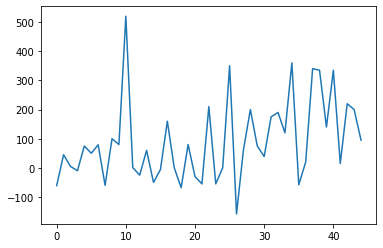

In [ ]:
### 이상한 개체 2 ###
lists_s=records[37]['v1']['anno']
lists_s
a=''.join(lists_s)
print(a)

signal_avl_0=records[37]['v1']['singal']
annoidx_avl_0=records[37]['v1']['anno_idx']

signal_bw=[]

for i in annoidx_avl_0:
  signal_bw.append(signal_avl_0[i+1])


print(signal_bw)
plt.plot(signal_bw)

(N)(N)(N)(N)(N)(N)(N)(N)(N)(N)(N)(N)(N)(N)
[119.99260231781834, 259.9992309340306, 279.9949461379155, 80.00117191004858, 199.99377422786694, 259.9992309340306, 99.99688711393347, 179.99805902398205, 197.99786492638026, 80.00117191004858, 140.00662861621228, 63.00847620564824, -1.007110197997865, 29.993572805827323, 93.00204901147556, 165.00127262106838, 179.99805902398205, 60.0054567061637, 21.99162450537156, 140.00662861621228, -85.0001007110198, -85.0001007110198, 140.00662861621228, 39.99143040776976, 179.99805902398205, 320.00468764019433, 140.00662861621228, 39.99143040776976, 179.99805902398205, -80.00117191004858, -39.00263130428095, 99.99688711393347, -19.99571520388488, 17.999805902398204, 220.00780052626087, -85.0001007110198, 39.99143040776976, 220.00780052626087, -50.007599104221256, -114.99367351684712, 0.0, -199.99377422786694]


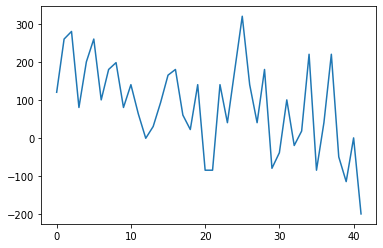

In [ ]:
### 이상한 개체 3 ###
lists_s=records[111]['v1']['anno']
lists_s
a=''.join(lists_s)
print(a)

signal_avl_0=records[111]['v1']['singal']
annoidx_avl_0=records[111]['v1']['anno_idx']

signal_bw=[]

for i in annoidx_avl_0:
  signal_bw.append(signal_avl_0[i+1])


print(signal_bw)
plt.plot(signal_bw)

In [ ]:
del scaled_dat[111]
del scaled_dat[103]
del scaled_dat[37]
len(scaled_dat)

197

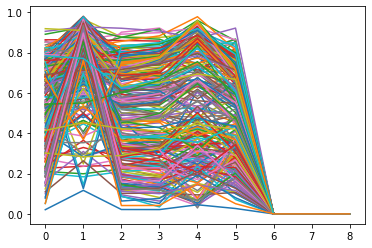

In [ ]:
##### anno_idx --> signal_ntp  (0값으로 채워넣기)
error_rec=[]

for i in udo_list:
  for j in range(0,len(scaled_dat)):
    index_=0
    a=scaled_dat[j][i]['anno']
    index_n=[]
    while True:
      if (index_+9)>=len(a):
        break
      if a[index_:(index_+9)]=='(N)(t)(p)':
        index_n.append(index_)
      index_=index_+1

    b=scaled_dat[j][i]['anno_idx']
    t=scaled_dat[j][i]['singal']

    if len(index_n)==0:
      index_=0
      while True:
        if (index_+6)>=len(a):
          break
        if a[index_:(index_+6)]=='(N)(t)':
          index_n.append(index_)
        index_=index_+1

      signal_mean=[]
      for z in range(0,9):
        val=0
        for c in index_n:
          if z<=5:
            val_sub_ind=b[c+z]
            val_sub=t[val_sub_ind+1]
            val=val_sub+val
          else:
            val=0
        #print(i,j)
        mean_val=val/len(index_n)
        #print(mean_val)   
        signal_mean.append(mean_val)
      scaled_dat[j][i].update({'signal_ntp': signal_mean})
      plt.plot(signal_mean)
      error_rec.append(j)

    else:
      signal_mean=[]
      for z in range(0,9):
        val=0
        for c in index_n:
          val_sub_ind=b[c+z]
        #print(c+z)
          val_sub=t[val_sub_ind+1]
          val=val_sub+val
        mean_val=val/len(index_n)
        signal_mean.append(mean_val)
      scaled_dat[j][i].update({'signal_ntp': signal_mean})
      #plt.plot(signal_mean)

In [ ]:
error_list=list(set(error_rec))
len(error_list)

21

In [ ]:
full_meanlists=dict()

for j in udo_list:
  udo_mean=[]
  for c in range(0,9):
    values=[]
    for i in range(len(scaled_dat)):
      lists=scaled_dat[i][j]['signal_ntp']
      if lists[c]!=0:
        values.append(lists[c])
    value_mean=np.mean(values)
    udo_mean.append(value_mean)
  full_meanlists[j]=udo_mean


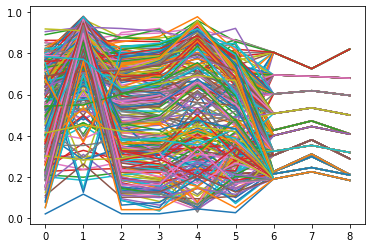

In [ ]:
##### anno_idx --> signal_ntp (mean 값으로 채워넣기)
error_rec=[]

for i in udo_list:
  for j in range(0,len(scaled_dat)):
    index_=0
    a=scaled_dat[j][i]['anno']
    index_n=[]
    while True:
      if (index_+9)>=len(a):
        break
      if a[index_:(index_+9)]=='(N)(t)(p)':
        index_n.append(index_)
      index_=index_+1

    b=scaled_dat[j][i]['anno_idx']
    t=scaled_dat[j][i]['singal']

    if len(index_n)==0:
      index_=0
      while True:
        if (index_+6)>=len(a):
          break
        if a[index_:(index_+6)]=='(N)(t)':
          index_n.append(index_)
        index_=index_+1

      signal_mean=[]
      for z in range(0,9):
        val=0
        if z<=5:
          for c in index_n:
            val_sub_ind=b[c+z]
            val_sub=t[val_sub_ind+1]
            val=val_sub+val
          mean_val=val/len(index_n)
        else:
          mean_val=full_meanlists[i][z]

        signal_mean.append(mean_val)
      scaled_dat[j][i].update({'signal_ntp': signal_mean})
      plt.plot(signal_mean)
      error_rec.append(j)

    else:
      signal_mean=[]
      for z in range(0,9):
        val=0
        for c in index_n:
          val_sub_ind=b[c+z]
        #print(c+z)
          val_sub=t[val_sub_ind+1]
          val=val_sub+val
        mean_val=val/len(index_n)
        signal_mean.append(mean_val)
      scaled_dat[j][i].update({'signal_ntp': signal_mean})
      #plt.plot(signal_mean)

In [ ]:
### 이상한 3개의 obs를 삭제한 나머지 scaled_dat을 활용하여 Y 생성 ###
scdrecord_Y_index=[]
scdrecord_N_index=[]
Y_list=[]

for i in range(0,len(scaled_dat)):
  lists_s=scaled_dat[i]['dignosis']
  if 'Left ventricular hypertrophy.' in lists_s:
    scdrecord_Y_index.append(i)
    Y_list.append(1)
  else:
    scdrecord_N_index.append(i)
    Y_list.append(0)
print('scdrecord_Y_index의 길이는 ',str(len(scdrecord_Y_index)))
print('scdrecord_N_index의 길이는 ',str(len(scdrecord_N_index)))

scdrecord_Y_index의 길이는  106
scdrecord_N_index의 길이는  91


In [ ]:
yes_records=[]
no_records=[]

for i in scdrecord_Y_index:
  yes_records.append(scaled_dat[i])

for i in scdrecord_N_index:
  no_records.append(scaled_dat[i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


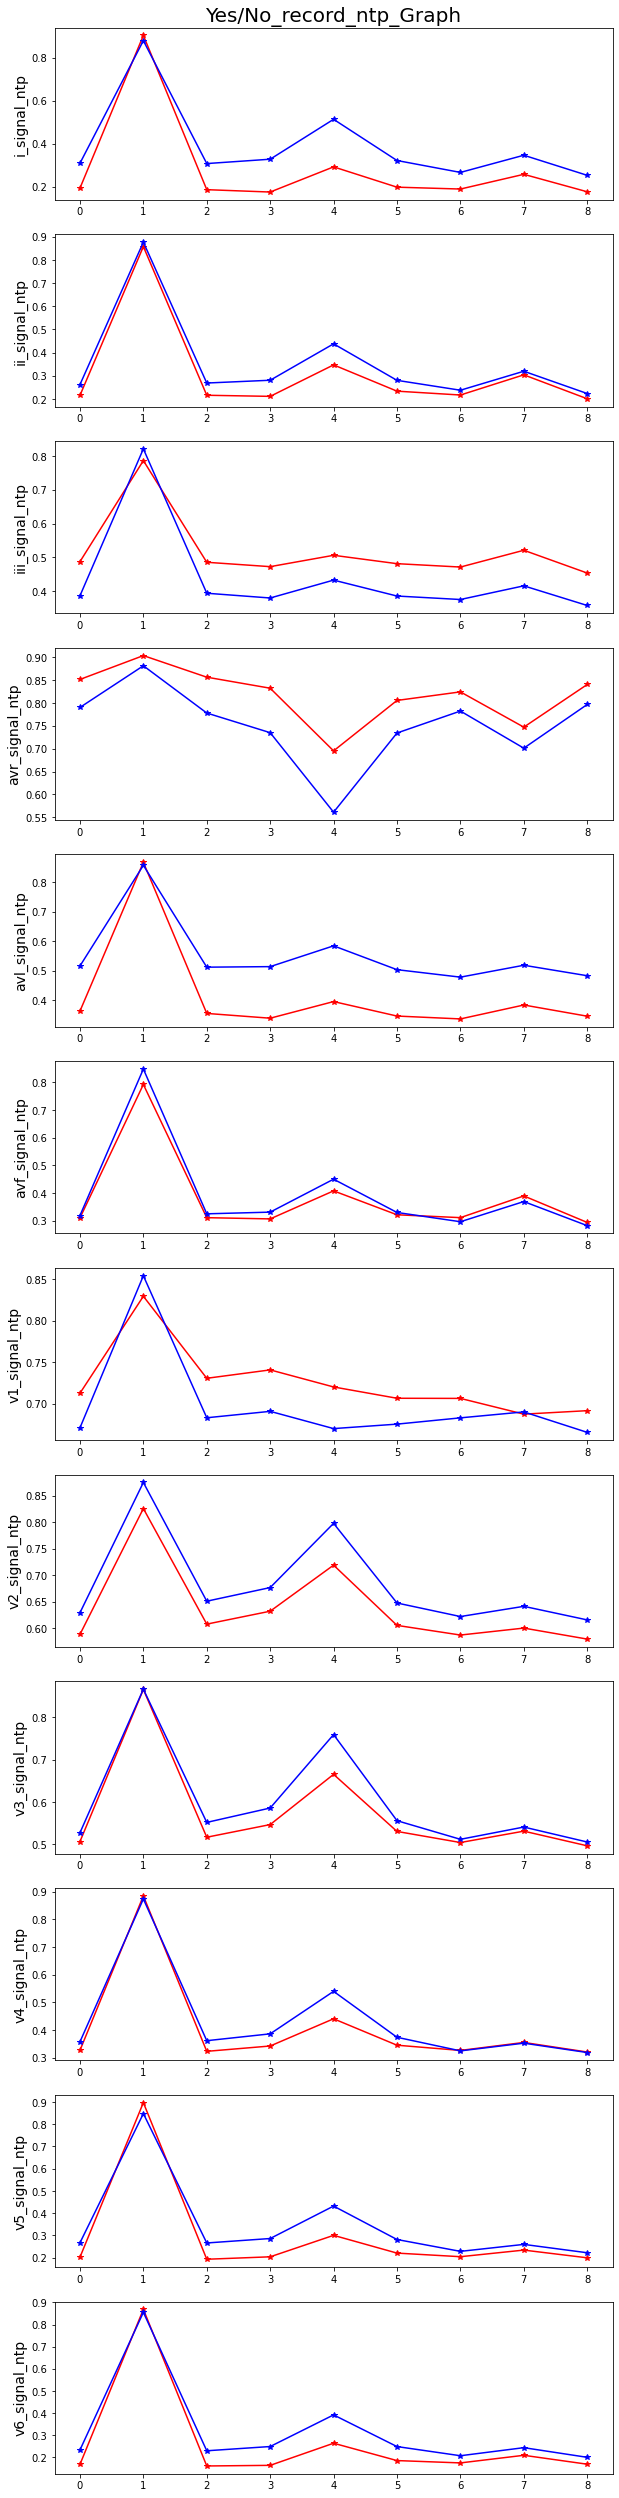

In [ ]:
full_meanlists_yes=dict()

for j in udo_list:
  udo_mean=[]
  for c in range(0,9):
    values=[]
    for i in range(len(yes_records)):
      lists=yes_records[i][j]['signal_ntp']
      if lists[c]!=0:
        values.append(lists[c])
    value_mean=np.mean(values)
    udo_mean.append(value_mean)
  full_meanlists_yes[j]=udo_mean

full_meanlists_no=dict()
for j in udo_list:
  udo_mean=[]
  for c in range(0,9):
    values=[]
    for i in range(len(no_records)):
      lists=no_records[i][j]['signal_ntp']
      if lists[c]!=0:
        values.append(lists[c])
    value_mean=np.mean(values)
    udo_mean.append(value_mean)
  full_meanlists_no[j]=udo_mean


plt.figure(figsize=(10, 45))
plt.subplot(12,1,1)
plt.title('Yes/No_record_ntp_Graph', fontsize=20) 
count=1

for i in udo_list:
  plt.subplot(12,1,count)
  plt.plot(full_meanlists_yes[i], marker='*',color='r')
  plt.plot(full_meanlists_no[i], marker='*',color='b')
  name=i+'_signal_ntp'
  plt.ylabel(name,fontsize=14)
  count=count+1

plt.show()

# 3.DNN모델링
저희가 디자인한 심전도 모델입니다.

## Data

In [ ]:
X_train=[]
for i in range(len(scaled_dat)):
  one_record=scaled_dat[i]
  for_onerec=[]
  for_onerec.append(one_record['sex'])
  for_onerec.append(one_record['age(10)'])
  for j in udo_list:
    for_onerec.extend(one_record[j]['signal_ntp'])
  X_train.append(for_onerec)

name=[]
name.append('sex')
name.append('age')
for i in udo_list:
  for j in range(0,9):
    new_name=str(i)+'_ntp_'+str(j+1)
    name.append(new_name)
len(name)

X_train_df=pd.DataFrame(X_train,columns=name)


sex_df=pd.get_dummies(X_train_df['sex'])
age_df=pd.get_dummies(X_train_df['age'])
dummy_df=pd.concat([sex_df,age_df],axis=1)
dummy_df=dummy_df.drop(columns=['F',90]) ### 더미화 했기 때문에 하나씩 컬럼 빼기
X_train_df=X_train_df.drop(columns=['sex','age'])
X_train_df=pd.concat([dummy_df,X_train_df],axis=1)
X_train_df

,M,10,20,30,40,50,60,70,80,i_ntp_1,i_ntp_2,i_ntp_3,i_ntp_4,i_ntp_5,i_ntp_6,i_ntp_7,i_ntp_8,i_ntp_9,ii_ntp_1,ii_ntp_2,ii_ntp_3,ii_ntp_4,ii_ntp_5,ii_ntp_6,ii_ntp_7,ii_ntp_8,ii_ntp_9,iii_ntp_1,iii_ntp_2,iii_ntp_3,iii_ntp_4,iii_ntp_5,iii_ntp_6,iii_ntp_7,iii_ntp_8,iii_ntp_9,avr_ntp_1,avr_ntp_2,avr_ntp_3,avr_ntp_4,...,v2_ntp_6,v2_ntp_7,v2_ntp_8,v2_ntp_9,v3_ntp_1,v3_ntp_2,v3_ntp_3,v3_ntp_4,v3_ntp_5,v3_ntp_6,v3_ntp_7,v3_ntp_8,v3_ntp_9,v4_ntp_1,v4_ntp_2,v4_ntp_3,v4_ntp_4,v4_ntp_5,v4_ntp_6,v4_ntp_7,v4_ntp_8,v4_ntp_9,v5_ntp_1,v5_ntp_2,v5_ntp_3,v5_ntp_4,v5_ntp_5,v5_ntp_6,v5_ntp_7,v5_ntp_8,v5_ntp_9,v6_ntp_1,v6_ntp_2,v6_ntp_3,v6_ntp_4,v6_ntp_5,v6_ntp_6,v6_ntp_7,v6_ntp_8,v6_ntp_9
0,0,0,0,0,0,1,0,0,0,0.098254,0.973553,0.086721,0.050011,0.226814,0.107233,0.091968,0.151173,0.083108,0.147099,0.956050,0.111774,0.062520,0.224375,0.142616,0.123551,0.204642,0.120234,0.826203,0.770550,0.805377,0.787799,0.700250,0.785684,0.803095,0.748903,0.794305,0.932890,0.958477,0.946925,0.959642,...,0.375069,0.337666,0.363869,0.329899,0.203369,0.921122,0.215674,0.217533,0.519968,0.229398,0.205493,0.231617,0.198679,0.164180,0.936644,0.164870,0.161159,0.372643,0.193011,0.171432,0.196203,0.165304,0.088916,0.949278,0.091131,0.064516,0.240983,0.113602,0.092676,0.122764,0.088141,0.055593,0.946193,0.079617,0.034590,0.195193,0.104187,0.073989,0.108441,0.062453
1,1,0,0,0,0,0,1,0,0,0.365911,0.863760,0.383599,0.296796,0.483465,0.281585,0.287038,0.351857,0.275958,0.213630,0.884585,0.273387,0.244268,0.356407,0.223687,0.214333,0.280166,0.208485,0.385432,0.789247,0.472596,0.410009,0.391617,0.400811,0.385960,0.468707,0.369520,0.814251,0.907737,0.782584,0.743000,...,0.669248,0.662074,0.682585,0.655633,0.647631,0.811056,0.699728,0.724574,0.968797,0.676134,0.656972,0.684803,0.650233,0.259594,0.917955,0.289277,0.303505,0.453358,0.280084,0.266945,0.289277,0.260954,0.147259,0.902825,0.178610,0.177547,0.351991,0.171979,0.153397,0.177381,0.138581,0.089833,0.917106,0.129624,0.128851,0.324292,0.129843,0.100967,0.144950,0.096774
2,1,0,0,0,0,1,0,0,0,0.341046,0.950236,0.308588,0.266144,0.423603,0.304762,0.305259,0.378330,0.288779,0.082858,0.938927,0.076788,0.030610,0.012278,0.090243,0.085366,0.153632,0.068474,0.104766,0.934013,0.108219,0.057838,0.009123,0.099157,0.099527,0.140408,0.089162,0.917375,0.962840,0.973121,0.969777,...,0.716868,0.710969,0.706957,0.711552,0.623444,0.972718,0.655105,0.688673,0.944128,0.622969,0.624483,0.631500,0.620285,0.317738,0.965938,0.318888,0.342284,0.541538,0.316458,0.320408,0.333203,0.315275,0.088496,0.939978,0.066647,0.073376,0.194618,0.093972,0.091886,0.116190,0.086779,0.078202,0.947617,0.052086,0.028838,0.135269,0.087943,0.083943,0.121452,0.079337
3,1,0,0,0,0,1,0,0,0,0.146269,0.873148,0.175481,0.214295,0.555542,0.181467,0.157315,0.203040,0.142144,0.277911,0.576951,0.308624,0.292606,0.317871,0.249508,0.277247,0.374178,0.265688,0.667428,0.779046,0.648064,0.584952,0.280467,0.608013,0.644080,0.656037,0.632881,0.889767,0.931652,0.895083,0.783650,...,0.528512,0.498762,0.515007,0.493027,0.478467,0.841073,0.533687,0.571306,0.985544,0.517857,0.484790,0.504963,0.478669,0.378777,0.950192,0.412151,0.443093,0.785615,0.409768,0.374952,0.397052,0.371725,0.167421,0.941078,0.186445,0.220412,0.506668,0.201701,0.180208,0.204850,0.169214,0.219621,0.932087,0.248989,0.274960,0.436033,0.251469,0.236322,0.271475,0.227605
4,1,0,0,0,0,0,1,0,0,0.178577,0.925385,0.220679,0.203841,0.404770,0.189319,0.166674,0.236938,0.160573,0.298758,0.923165,0.364360,0.335103,0.547281,0.316490,0.312647,0.409279,0.297578,0.597466,0.391891,0.651931,0.520068,0.618348,0.554875,0.574938,0.604015,0.533993,0.874849,0.931516,0.792426,0.744847,...,0.618903,0.591126,0.611110,0.587738,0.584699,0.967566,0.587746,0.643595,0.889729,0.609193,0.585353,0.603206,0.575447,0.430517,0.963101,0.439072,0.466768,0.663144,0.439070,0.430512,0.449072,0.424113,0.315732,0.967872,0.313028,0.341093,0.520119,0.325930,0.321060,0.341901,0.316276,0.249652,0.861822,0.266366,0.290376,0.453749,0.266953,0.306497,0.353463,0.263540
...,...,...

In [ ]:
##### keras model에 넣어주려면 array 형태로 변환해야함 #####
X_train=X_train_df.to_numpy()
X_train.shape
Y_train=np.array(Y_list)
Y_train.shape

(197,)

## train / validation simple model

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(X_train,Y_train, test_size=0.15,random_state=12)

print(x_train.shape,x_val.shape)

(167, 117) (30, 117)


In [ ]:
## batchnormalization 설명 https://nittaku.tistory.com/293
## batch size 설명 http://melonicedlatte.com/machinelearning/2019/06/23/154900.html
## Dropout 설명 https://jyunleee.blogspot.com/2019/07/dropout.html

from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization
from keras import regularizers

model=Sequential()
model.add(Dense(64,input_dim=117,activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(Dense(32,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization(axis=1))
model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

simple_mod=model.fit(x_train,y_train,epochs=120,validation_data=(x_val,y_val))

Epoch 1/120
6/6 [==============================] - 0s 30ms/step - loss: 0.9772 - accuracy: 0.5030 - val_loss: 0.7498 - val_accuracy: 0.5000
Epoch 2/120
6/6 [==============================] - 0s 5ms/step - loss: 0.7546 - accuracy: 0.6168 - val_loss: 0.7358 - val_accuracy: 0.5000
Epoch 3/120
6/6 [==============================] - 0s 5ms/step - loss: 0.6492 - accuracy: 0.6587 - val_loss: 0.7315 - val_accuracy: 0.5000
Epoch 4/120
6/6 [==============================] - 0s 5ms/step - loss: 0.5545 - accuracy: 0.7725 - val_loss: 0.7269 - val_accuracy: 0.4333
Epoch 5/120
6/6 [==============================] - 0s 5ms/step - loss: 0.5302 - accuracy: 0.8024 - val_loss: 0.7243 - val_accuracy: 0.5333
Epoch 6/120
6/6 [==============================] - 0s 5ms/step - loss: 0.4953 - accuracy: 0.8144 - val_loss: 0.7182 - val_accuracy: 0.5667
Epoch 7/120
6/6 [==============================] - 0s 5ms/step - loss: 0.4559 - accuracy: 0.8144 - val_loss: 0.7056 - val_accuracy: 0.6000
Epoch 8/120
6/6 [=========

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


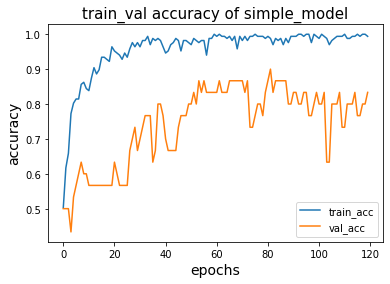

In [ ]:
print(simple_mod.history.keys())
train_accuracy=simple_mod.history['accuracy']
val_accuracy=simple_mod.history['val_accuracy']
train_loss=simple_mod.history['loss']
val_loss=simple_mod.history['val_loss']

plt.title('train_val accuracy of simple_model', fontsize=15) 
plt.plot(train_accuracy,label='train_acc')
plt.plot(val_accuracy,label='val_acc')

plt.legend(loc='lower right')
plt.ylabel('accuracy', fontsize=14)
plt.xlabel('epochs', fontsize=14)
plt.show()

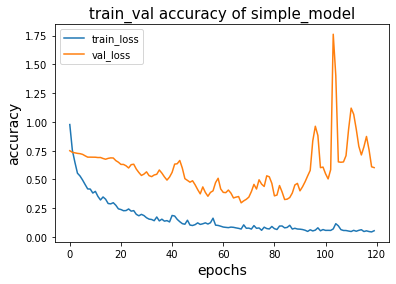

In [ ]:
plt.title('train_val accuracy of simple_model', fontsize=15) 

plt.plot(train_loss,label='train_loss')
plt.plot(val_loss,label='val_loss')
plt.legend(loc='upper left')
plt.ylabel('accuracy', fontsize=14)
plt.xlabel('epochs', fontsize=14)
plt.show()

## train / validation Earlystopping model

In [ ]:
## batchnormalization 설명 https://nittaku.tistory.com/293
## batch size 설명 http://melonicedlatte.com/machinelearning/2019/06/23/154900.html
## Dropout 설명 https://jyunleee.blogspot.com/2019/07/dropout.html
## early stopping https://tykimos.github.io/2017/07/09/Early_Stopping/


from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization
from keras import regularizers
from keras.callbacks import EarlyStopping

model=Sequential()
model.add(Dense(64,input_dim=117,activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(Dense(32,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization(axis=1))
model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

early_stopping = EarlyStopping(patience = 30)
simple_mod=model.fit(x_train,y_train,epochs=200,validation_data=(x_val,y_val),callbacks=[early_stopping])

Epoch 1/200
6/6 [==============================] - 0s 25ms/step - loss: 0.8083 - accuracy: 0.4551 - val_loss: 0.7269 - val_accuracy: 0.6000
Epoch 2/200
6/6 [==============================] - 0s 5ms/step - loss: 0.7180 - accuracy: 0.5689 - val_loss: 0.7170 - val_accuracy: 0.6000
Epoch 3/200
6/6 [==============================] - 0s 5ms/step - loss: 0.6516 - accuracy: 0.6647 - val_loss: 0.7093 - val_accuracy: 0.6333
Epoch 4/200
6/6 [==============================] - 0s 5ms/step - loss: 0.5994 - accuracy: 0.7305 - val_loss: 0.7044 - val_accuracy: 0.6333
Epoch 5/200
6/6 [==============================] - 0s 5ms/step - loss: 0.5842 - accuracy: 0.7605 - val_loss: 0.7010 - val_accuracy: 0.6333
Epoch 6/200
6/6 [==============================] - 0s 5ms/step - loss: 0.5523 - accuracy: 0.7665 - val_loss: 0.7008 - val_accuracy: 0.6333
Epoch 7/200
6/6 [==============================] - 0s 5ms/step - loss: 0.5180 - accuracy: 0.7665 - val_loss: 0.7004 - val_accuracy: 0.6667
Epoch 8/200
6/6 [=========

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


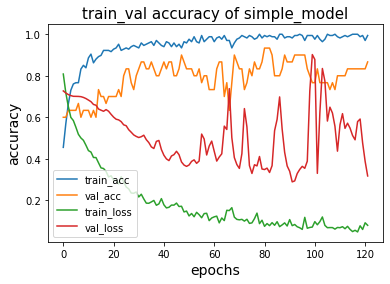

In [ ]:
print(simple_mod.history.keys())
train_accuracy=simple_mod.history['accuracy']
val_accuracy=simple_mod.history['val_accuracy']
train_loss=simple_mod.history['loss']
val_loss=simple_mod.history['val_loss']

plt.title('train_val accuracy of simple_model', fontsize=15) 
plt.plot(train_accuracy,label='train_acc')
plt.plot(val_accuracy,label='val_acc')
plt.plot(train_loss,label='train_loss')
plt.plot(val_loss,label='val_loss')
plt.legend(loc='lower left')
plt.ylabel('accuracy', fontsize=14)
plt.xlabel('epochs', fontsize=14)
plt.show()

In [ ]:
## batchnormalization 설명 https://nittaku.tistory.com/293
## batch size 설명 http://melonicedlatte.com/machinelearning/2019/06/23/154900.html
## Dropout 설명 https://jyunleee.blogspot.com/2019/07/dropout.html
## early stopping https://tykimos.github.io/2017/07/09/Early_Stopping/


from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization
from keras import regularizers
from keras.callbacks import EarlyStopping

model=Sequential()
model.add(Dense(64,input_dim=117,activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(Dense(32,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization(axis=1))
model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

early_stopping = EarlyStopping(patience = 40)
simple_mod=model.fit(x_train,y_train,epochs=200,validation_data=(x_val,y_val),callbacks=[early_stopping])

Epoch 1/200
6/6 [==============================] - 0s 24ms/step - loss: 0.9168 - accuracy: 0.5269 - val_loss: 0.7433 - val_accuracy: 0.4333
Epoch 2/200
6/6 [==============================] - 0s 5ms/step - loss: 0.6812 - accuracy: 0.6228 - val_loss: 0.7385 - val_accuracy: 0.5000
Epoch 3/200
6/6 [==============================] - 0s 5ms/step - loss: 0.5926 - accuracy: 0.6707 - val_loss: 0.7385 - val_accuracy: 0.5000
Epoch 4/200
6/6 [==============================] - 0s 5ms/step - loss: 0.5550 - accuracy: 0.6946 - val_loss: 0.7334 - val_accuracy: 0.5000
Epoch 5/200
6/6 [==============================] - 0s 5ms/step - loss: 0.5404 - accuracy: 0.7246 - val_loss: 0.7265 - val_accuracy: 0.5333
Epoch 6/200
6/6 [==============================] - 0s 5ms/step - loss: 0.5069 - accuracy: 0.7305 - val_loss: 0.7203 - val_accuracy: 0.5667
Epoch 7/200
6/6 [==============================] - 0s 5ms/step - loss: 0.4880 - accuracy: 0.7605 - val_loss: 0.7169 - val_accuracy: 0.6000
Epoch 8/200
6/6 [=========

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


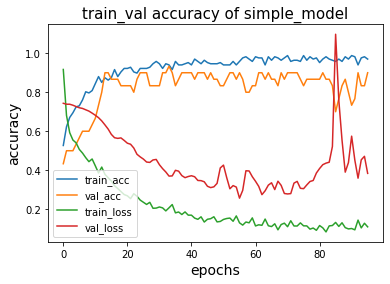

In [ ]:
print(simple_mod.history.keys())
train_accuracy=simple_mod.history['accuracy']
val_accuracy=simple_mod.history['val_accuracy']
train_loss=simple_mod.history['loss']
val_loss=simple_mod.history['val_loss']

plt.title('train_val accuracy of simple_model', fontsize=15) 
plt.plot(train_accuracy,label='train_acc')
plt.plot(val_accuracy,label='val_acc')
plt.plot(train_loss,label='train_loss')
plt.plot(val_loss,label='val_loss')
plt.legend(loc='lower left')
plt.ylabel('accuracy', fontsize=14)
plt.xlabel('epochs', fontsize=14)
plt.show()

## 7-fold cross validation

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

from sklearn.model_selection import KFold

kfold=KFold(n_splits=7,shuffle=True,random_state=123)
acc_per_train=[]
acc_per_fold=[]
loss_per_fold=[]
precision_per_fold=[]
recall_per_fold=[]


fold_no=1
for train, val in kfold.split(X_train,Y_train):
  model=Sequential()
  model.add(Dense(64,input_dim=117,activation='relu'))
  model.add(BatchNormalization(axis=1))
  model.add(Dense(32,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
  model.add(BatchNormalization(axis=1))
  model.add(Dense(8,activation='relu'))
  model.add(Dense(1,activation='sigmoid'))

  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(X_train[train], Y_train[train],epochs=100,verbose=1)
  acc_per_train.append(history.history['accuracy'][-1])


  # Generate generalization metrics
  scores = model.evaluate(X_train[val], Y_train[val], verbose=0)
  pred_1 = model.predict(X_train[val])
  #print(pred_1)
  pred_idx_list=[]
  for pred in pred_1:
    if pred>0.5:
      pred_idx_list.append(1)
    else:
      pred_idx_list.append(0)
  #print(pred_idx_list)
  pred_idx_arr = np.array(pred_idx_list, dtype=np.float32)
  precision_sc=precision_score( Y_train[val], pred_idx_arr)
  acc=accuracy_score(Y_train[val], pred_idx_arr)
  #print(acc)
  recall_sc=recall_score(Y_train[val], pred_idx_arr)
  precision_per_fold.append(precision_sc)
  recall_per_fold.append(recall_sc)


  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
6/6 [==============================] - 0s 5ms/step - loss: 0.8899 - accuracy: 0.4940
Epoch 2/100
6/6 [==============================] - 0s 4ms/step - loss: 0.7104 - accuracy: 0.6190
Epoch 3/100
6/6 [==============================] - 0s 65ms/step - loss: 0.6215 - accuracy: 0.7083
Epoch 4/100
6/6 [==============================] - 0s 5ms/step - loss: 0.5640 - accuracy: 0.7857
Epoch 5/100
6/6 [==============================] - 0s 4ms/step - loss: 0.5095 - accuracy: 0.8631
Epoch 6/100
6/6 [==============================] - 0s 4ms/step - loss: 0.4866 - accuracy: 0.8512
Epoch 7/100
6/6 [==============================] - 0s 4ms/step - loss: 0.4611 - accuracy: 0.8333
Epoch 8/100
6/6 [==============================] - 0s 4ms/step - loss: 0.4497 - accuracy: 0.8512
Epoch 9/100
6/6 [==============================] - 0s 4ms/step - loss: 0.4131 - accuracy: 0.8869
Epoch 10/100
6/6 [===========

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}% - Precision: {precision_per_fold[i]} - Recall: {recall_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.5633392930030823 - Accuracy: 79.31034564971924% - Precision: 0.8333333333333334 - Recall: 0.7142857142857143
------------------------------------------------------------------------
> Fold 2 - Loss: 0.537846565246582 - Accuracy: 89.28571343421936% - Precision: 0.8666666666666667 - Recall: 0.9285714285714286
------------------------------------------------------------------------
> Fold 3 - Loss: 0.7385379076004028 - Accuracy: 82.14285969734192% - Precision: 0.75 - Recall: 1.0
------------------------------------------------------------------------
> Fold 4 - Loss: 1.256752610206604 - Accuracy: 64.28571343421936% - Precision: 1.0 - Recall: 0.4444444444444444
------------------------------------------------------------------------
> Fold 5 - Loss: 0.3527984619140625 - Accuracy: 89.28571343421936% - Precision: 0

# 4.1D-CNN 모델링
논문에서 아이디어를 얻고 kaggle을 참고한 CNN 모델입니다.

## Data Preprocessing

In [ ]:
### 따로 학습에 필요한 시그널 데이터를 만들었다. ###
num_records = 200
x_records = []
y_records = []
for i in range(1,num_records+1):
    record = wfdb.io.rdrecord(f'{data_dir}/{i}')
    x_data = {}
    cols = ['avl', 'v1', 'v5', 'v6']
    num = [4, 6, 10, 11]
    for col, j in zip(cols, num):
        x_data[col] = record.p_signal[:, j]
    y_data = {'dignosis':record.comments[3:]}
    y_records.append(y_data)
    x_records.append(x_data)

In [ ]:
### X 데이터 ###
df=pd.DataFrame(x_records)
avl=np.array(df['avl'].tolist())
v1=np.array(df['v1'].tolist())
v5=np.array(df['v5'].tolist())
v6=np.array(df['v6'].tolist())

sum_x = []    
for i in range(0,200) :              
    one=(avl[i],v1[i],v5[i],v6[i])     
    sum_x.append(one)

pre_x=np.array(sum_x)
trans_x=np.transpose(pre_x,(0,2,1))
x=trans_x[:,:,:,np.newaxis]
x.shape

(200, 5000, 4, 1)

In [ ]:
### Y에 대한 데이터 ###
df=pd.DataFrame(y_records)
def func(z) :
  if "Left ventricular hypertrophy." in z:
      return 1
  else :
      return 0
df["LVH"] = df["dignosis"].apply(lambda z : func(z))
pre_y=df["LVH"]
low_y=np.array(pre_y)
y=low_y[:,np.newaxis]
y.shape

(200, 1)

## Standard_Model with test, train, val

In [ ]:
### 테스트 셋과 트레이닝 셋 ###
from sklearn.model_selection import train_test_split
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=.2,random_state=0)

In [ ]:
### 트레이닝 셋과 validation 셋 ###
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, 
                                                  stratify=y_train_all, 
                                                  test_size=.2, 
                                                  random_state=0)

In [ ]:
 ### 가장 기본이 되는 모델 ###
 import tensorflow as tf
 def return_model1():
    input_tens = tf.keras.Input(shape=(5000,4,1))
    x = tf.keras.layers.Conv2D(256, kernel_size=(250,4), strides=(5,1),padding='valid')(input_tens)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Conv2D(512, kernel_size=(5,1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Conv2D(512, kernel_size=(5,1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Conv2D(128, kernel_size=(5,1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=(5,1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs=input_tens, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.binary_crossentropy, metrics=["accuracy"])
    print(model.summary())
    return model

In [ ]:
model1 = return_model1()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5000, 4, 1)]      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 951, 1, 256)       256256    
_________________________________________________________________
batch_normalization_5 (Batch (None, 951, 1, 256)       1024      
_________________________________________________________________
re_lu_5 (ReLU)               (None, 951, 1, 256)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 947, 1, 512)       655872    
_________________________________________________________________
batch_normalization_6 (Batch (None, 947, 1, 512)       2048      
_________________________________________________________________
re_lu_6 (ReLU)               (None, 947, 1, 512)      

In [ ]:
### train test셋으로 학습 ###
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=30)

history_1=model1.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test),callbacks=[early_stopping])


Epoch 1/100
1/1 [==============================] - 0s 200ms/step - loss: 0.7012 - accuracy: 0.4688 - val_loss: 19.5179 - val_accuracy: 0.4500
Epoch 2/100
1/1 [==============================] - 0s 58ms/step - loss: 0.7037 - accuracy: 0.5625 - val_loss: 8.3237 - val_accuracy: 0.5500
Epoch 3/100
1/1 [==============================] - 0s 58ms/step - loss: 0.6380 - accuracy: 0.6875 - val_loss: 2.3963 - val_accuracy: 0.5500
Epoch 4/100
1/1 [==============================] - 0s 58ms/step - loss: 0.5459 - accuracy: 0.7578 - val_loss: 3.1525 - val_accuracy: 0.4750
Epoch 5/100
1/1 [==============================] - 0s 58ms/step - loss: 0.4930 - accuracy: 0.7969 - val_loss: 4.1446 - val_accuracy: 0.4750
Epoch 6/100
1/1 [==============================] - 0s 57ms/step - loss: 0.4304 - accuracy: 0.8594 - val_loss: 1.5881 - val_accuracy: 0.6250
Epoch 7/100
1/1 [==============================] - 0s 59ms/step - loss: 0.3738 - accuracy: 0.8672 - val_loss: 1.3936 - val_accuracy: 0.6250
Epoch 8/100
1/1 [=

In [ ]:
### test accurracy와 confusion_matrix ###
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

pred_1 = model1.predict(x_test)
pred_tot1 = pred_1

pred_idx_list=[]

for pred in pred_1:
    if pred > 0.5:
      pred_idx_list.append(1)
    else:
      pred_idx_list.append(0)
    
pred_idx_arr = np.array(pred_idx_list, dtype=np.float32)
print('predict accuracy :',accuracy_score(y_test, pred_idx_arr))
print('precision score :',precision_score(y_test, pred_idx_arr))
print('recall score:',recall_score(y_test, pred_idx_arr))
print(confusion_matrix(y_test, pred_idx_arr))


predict accuracy : 0.825
precision score : 0.8571428571428571
recall score: 0.8181818181818182
[[15  3]
 [ 4 18]]


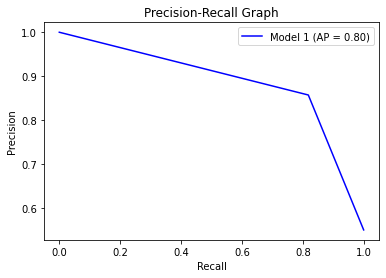

In [ ]:
### AP 그래프 ###
import matplotlib.pyplot as pp
import numpy as np
import sklearn.metrics as metrics

model1PrecisionNDArray, model1RecallRateNDArray, _ = metrics.precision_recall_curve(y_test,pred_idx_arr)

model1AP = metrics.average_precision_score(y_test,pred_idx_arr)
pp.title("Precision-Recall Graph")
pp.xlabel("Recall"   )
pp.ylabel("Precision")

pp.plot(model1RecallRateNDArray, model1PrecisionNDArray, "b", label = "Model 1 (AP = %0.2F)" % model1AP)
pp.legend(loc = "upper right")
pp.show()


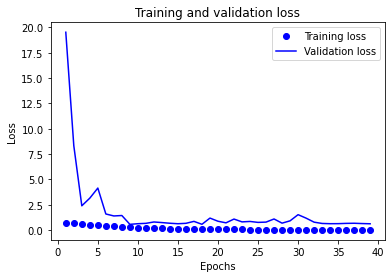

In [ ]:
### train과 test의 loss 그래프 ###
history_dict = history_1.history
history_dict.keys()
[u'acc', u'loss', u'val_acc', u'val_loss']

import matplotlib.pyplot as plt

history_dict = history_1.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

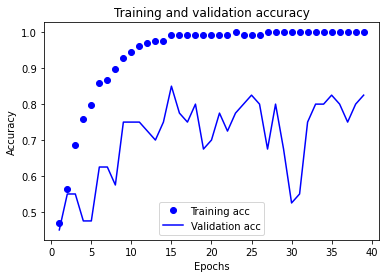

In [ ]:
#train과 test의 accuracy 그래프
plt.clf() 
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Standard with K-fold

In [ ]:
### 모델1과 같은 조건으로 cv을 할 모델 ###
def return_model1():
    input_tens = tf.keras.Input(shape=(5000,4,1))
    x = tf.keras.layers.Conv2D(256, kernel_size=(250,4), strides=(5,1),padding='valid')(input_tens)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Conv2D(512, kernel_size=(5,1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Conv2D(512, kernel_size=(5,1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Conv2D(128, kernel_size=(5,1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=(5,1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs=input_tens, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.binary_crossentropy, metrics=["accuracy"])
    print(model.summary())
    return model

In [ ]:
import tensorflow as tf
model1_cv = return_model1()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 5000, 4, 1)]      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 951, 1, 256)       256256    
_________________________________________________________________
batch_normalization_15 (Batc (None, 951, 1, 256)       1024      
_________________________________________________________________
re_lu_15 (ReLU)              (None, 951, 1, 256)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 951, 1, 256)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 947, 1, 512)       655872    
_________________________________________________________________
batch_normalization_16 (Batc (None, 947, 1, 512)      

In [ ]:
### k-fold cv ### 
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, average_precision_score

kfold=KFold(n_splits=7,shuffle=True,random_state=123)
acc_per_train=[]
acc_per_fold=[]
loss_per_fold=[]
precision_per_fold=[]
recall_per_fold=[]
AP_per_fold=[]

fold_no=1
for train, val in kfold.split(x,y):
  model1_cv


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history1_cv = model1_cv.fit(x[train], y[train],epochs=100,verbose=1)
  acc_per_train.append(history1_cv.history['accuracy'][-1])


  # Generate generalization metrics
  scores = model1_cv.evaluate(x[val], y[val], verbose=0)
  pred_1 = model1_cv.predict(x[val])
  #print(pred_1)
  pred_idx_list=[]
  for pred in pred_1:
    if pred>0.5:
      pred_idx_list.append(1)
    else:
      pred_idx_list.append(0)
  #print(pred_idx_list)
  pred_idx_arr = np.array(pred_idx_list, dtype=np.float32)
  precision_sc=precision_score( y[val], pred_idx_arr)
  acc=accuracy_score(y[val], pred_idx_arr)
  AP_sc=average_precision_score(y[val],pred_idx_arr)
  recall_sc=recall_score(y[val], pred_idx_arr)
  precision_per_fold.append(precision_sc)
  recall_per_fold.append(recall_sc)
  AP_per_fold.append(AP_sc)

  
  
  print(f'Score for fold {fold_no}: {model1_cv.metrics_names[0]} of {scores[0]}; {model1_cv.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
6/6 [==============================] - 1s 111ms/step - loss: 0.8157 - accuracy: 0.4444
Epoch 2/100
6/6 [==============================] - 1s 98ms/step - loss: 0.6822 - accuracy: 0.5497
Epoch 3/100
6/6 [==============================] - 1s 98ms/step - loss: 0.6168 - accuracy: 0.6959
Epoch 4/100
6/6 [==============================] - 1s 99ms/step - loss: 0.5501 - accuracy: 0.7427
Epoch 5/100
6/6 [==============================] - 1s 99ms/step - loss: 0.5441 - accuracy: 0.7427
Epoch 6/100
6/6 [==============================] - 1s 98ms/step - loss: 0.4577 - accuracy: 0.7953
Epoch 7/100
6/6 [==============================] - 1s 99ms/step - loss: 0.4099 - accuracy: 0.8304
Epoch 8/100
6/6 [==============================] - 1s 99ms/step - loss: 0.3522 - accuracy: 0.8304
Epoch 9/100
6/6 [==============================] - 1s 98ms/step - loss: 0.3288 - accuracy: 0.8772
Epoch 10/100
6/6 [==

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}% Precision: {precision_per_fold[i]} - Recall: {recall_per_fold[i]}-AP : {AP_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print(f'> AP: {np.mean(AP_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.634103536605835 - Accuracy: 75.86206793785095% Precision: 0.75 - Recall: 0.8823529411764706-AP : 0.7307302231237323
------------------------------------------------------------------------
> Fold 2 - Loss: 0.13012497127056122 - Accuracy: 89.65517282485962% Precision: 0.85 - Recall: 1.0-AP : 0.85
------------------------------------------------------------------------
> Fold 3 - Loss: 0.11483889818191528 - Accuracy: 96.55172228813171% Precision: 0.9375 - Recall: 1.0-AP : 0.9375
------------------------------------------------------------------------
> Fold 4 - Loss: 0.12708641588687897 - Accuracy: 96.55172228813171% Precision: 0.9444444444444444 - Recall: 1.0-AP : 0.9444444444444444
------------------------------------------------------------------------
> Fold 5 - Loss: 0.0196569561958313 - Accuracy: 100.0% P

## 커널의 크기를 조정

In [ ]:
 ### 커널 사이즈 (500,4) ###
 import tensorflow as tf
 def return_model2():
    input_tens = tf.keras.Input(shape=(5000,4,1))
    x = tf.keras.layers.Conv2D(256, kernel_size=(500,4), strides=(5,1),padding='valid')(input_tens)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Conv2D(512, kernel_size=(5,1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Conv2D(512, kernel_size=(5,1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Conv2D(128, kernel_size=(5,1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=(5,1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs=input_tens, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.binary_crossentropy, metrics=["accuracy"])
    print(model.summary())
    return model

In [ ]:
model2 = return_model2()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 5000, 4, 1)]      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 901, 1, 256)       512256    
_________________________________________________________________
batch_normalization_20 (Batc (None, 901, 1, 256)       1024      
_________________________________________________________________
re_lu_20 (ReLU)              (None, 901, 1, 256)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 901, 1, 256)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 897, 1, 512)       655872    
_________________________________________________________________
batch_normalization_21 (Batc (None, 897, 1, 512)      

In [ ]:
### k-fold cv ### 
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, average_precision_score

kfold=KFold(n_splits=7,shuffle=True,random_state=123)
acc_per_train=[]
acc_per_fold=[]
loss_per_fold=[]
precision_per_fold=[]
recall_per_fold=[]
AP_per_fold=[]

fold_no=1
for train, val in kfold.split(x,y):
  model2


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history2 = model2.fit(x[train], y[train],epochs=100,verbose=1)
  acc_per_train.append(history2.history['accuracy'][-1])


  # Generate generalization metrics
  scores = model2.evaluate(x[val], y[val], verbose=0)
  prediction = model2.predict(x[val])
  #print(pred_1)
  pred_idx_list=[]
  for p in prediction:
    if p > 0.5:
      pred_idx_list.append(1)
    else:
      pred_idx_list.append(0)
  #print(pred_idx_list)
  pred_idx_arr = np.array(pred_idx_list, dtype=np.float32)
  precision_sc=precision_score( y[val], pred_idx_arr)
  acc=accuracy_score(y[val], pred_idx_arr)
  AP_sc=average_precision_score(y[val],pred_idx_arr)
  recall_sc=recall_score(y[val], pred_idx_arr)
  precision_per_fold.append(precision_sc)
  recall_per_fold.append(recall_sc)
  AP_per_fold.append(AP_sc)

  
  
  print(f'Score for fold {fold_no}: {model2.metrics_names[0]} of {scores[0]}; {model2.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
6/6 [==============================] - 1s 146ms/step - loss: 0.7941 - accuracy: 0.5205
Epoch 2/100
6/6 [==============================] - 1s 101ms/step - loss: 0.7003 - accuracy: 0.5322
Epoch 3/100
6/6 [==============================] - 1s 100ms/step - loss: 0.6669 - accuracy: 0.5731
Epoch 4/100
6/6 [==============================] - 1s 100ms/step - loss: 0.6464 - accuracy: 0.6316
Epoch 5/100
6/6 [==============================] - 1s 100ms/step - loss: 0.5807 - accuracy: 0.7193
Epoch 6/100
6/6 [==============================] - 1s 100ms/step - loss: 0.5188 - accuracy: 0.7427
Epoch 7/100
6/6 [==============================] - 1s 100ms/step - loss: 0.5236 - accuracy: 0.7368
Epoch 8/100
6/6 [==============================] - 1s 100ms/step - loss: 0.4082 - accuracy: 0.7836
Epoch 9/100
6/6 [==============================] - 1s 100ms/step - loss: 0.3634 - accuracy: 0.8421
Epoch 10/100

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}% Precision: {precision_per_fold[i]} - Recall: {recall_per_fold[i]}-AP : {AP_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print(f'> AP: {np.mean(AP_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.9738743305206299 - Accuracy: 82.75862336158752% Precision: 0.7727272727272727 - Recall: 1.0-AP : 0.7727272727272727
------------------------------------------------------------------------
> Fold 2 - Loss: 0.110985666513443 - Accuracy: 93.1034505367279% Precision: 0.8947368421052632 - Recall: 1.0-AP : 0.8947368421052632
------------------------------------------------------------------------
> Fold 3 - Loss: 0.48077720403671265 - Accuracy: 75.86206793785095% Precision: 0.6818181818181818 - Recall: 1.0-AP : 0.6818181818181818
------------------------------------------------------------------------
> Fold 4 - Loss: 0.43120673298835754 - Accuracy: 89.65517282485962% Precision: 0.85 - Recall: 1.0-AP : 0.85
------------------------------------------------------------------------
> Fold 5 - Loss: 0.1569705009460449

In [ ]:
 ### 커널 사이즈 (400,4) ###
 import tensorflow as tf
 def return_model3():
    input_tens = tf.keras.Input(shape=(5000,4,1))
    x = tf.keras.layers.Conv2D(256, kernel_size=(400,4), strides=(5,1),padding='valid')(input_tens)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Conv2D(512, kernel_size=(5,1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Conv2D(512, kernel_size=(5,1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Conv2D(128, kernel_size=(5,1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=(5,1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs=input_tens, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.binary_crossentropy, metrics=["accuracy"])
    print(model.summary())
    return model

In [ ]:
model3 = return_model3()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5000, 4, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 921, 1, 256)       409856    
_________________________________________________________________
batch_normalization (BatchNo (None, 921, 1, 256)       1024      
_________________________________________________________________
re_lu (ReLU)                 (None, 921, 1, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 921, 1, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 917, 1, 512)       655872    
_________________________________________________________________
batch_normalization_1 (Batch (None, 917, 1, 512)      

In [ ]:
### k-fold cv ### 
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, average_precision_score

kfold=KFold(n_splits=7,shuffle=True,random_state=123)
acc_per_train=[]
acc_per_fold=[]
loss_per_fold=[]
precision_per_fold=[]
recall_per_fold=[]
AP_per_fold=[]

fold_no=1
for train, val in kfold.split(x,y):
  model3


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history3 = model3.fit(x[train], y[train],epochs=100,verbose=1)
  acc_per_train.append(history3.history['accuracy'][-1])


  # Generate generalization metrics
  scores = model3.evaluate(x[val], y[val], verbose=0)
  prediction = model3.predict(x[val])
  #print(pred_1)
  pred_idx_list=[]
  for p in prediction:
    if p > 0.5:
      pred_idx_list.append(1)
    else:
      pred_idx_list.append(0)
  #print(pred_idx_list)
  pred_idx_arr = np.array(pred_idx_list, dtype=np.float32)
  precision_sc=precision_score( y[val], pred_idx_arr)
  acc=accuracy_score(y[val], pred_idx_arr)
  AP_sc=average_precision_score(y[val],pred_idx_arr)
  recall_sc=recall_score(y[val], pred_idx_arr)
  precision_per_fold.append(precision_sc)
  recall_per_fold.append(recall_sc)
  AP_per_fold.append(AP_sc)

  
  
  print(f'Score for fold {fold_no}: {model3.metrics_names[0]} of {scores[0]}; {model3.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
6/6 [==============================] - 1s 94ms/step - loss: 0.7579 - accuracy: 0.5205
Epoch 2/100
6/6 [==============================] - 0s 59ms/step - loss: 0.6537 - accuracy: 0.6374
Epoch 3/100
6/6 [==============================] - 0s 58ms/step - loss: 0.6669 - accuracy: 0.6257
Epoch 4/100
6/6 [==============================] - 0s 58ms/step - loss: 0.5266 - accuracy: 0.7310
Epoch 5/100
6/6 [==============================] - 0s 59ms/step - loss: 0.4765 - accuracy: 0.7602
Epoch 6/100
6/6 [==============================] - 0s 58ms/step - loss: 0.4028 - accuracy: 0.8012
Epoch 7/100
6/6 [==============================] - 0s 58ms/step - loss: 0.3609 - accuracy: 0.8304
Epoch 8/100
6/6 [==============================] - 0s 58ms/step - loss: 0.3323 - accuracy: 0.8713
Epoch 9/100
6/6 [==============================] - 0s 57ms/step - loss: 0.3097 - accuracy: 0.8596
Epoch 10/100
6/6 [===

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}% Precision: {precision_per_fold[i]} - Recall: {recall_per_fold[i]}-AP : {AP_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print(f'> AP: {np.mean(AP_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.9607096910476685 - Accuracy: 75.86206793785095% Precision: 0.75 - Recall: 0.8823529411764706-AP : 0.7307302231237323
------------------------------------------------------------------------
> Fold 2 - Loss: 0.045207489281892776 - Accuracy: 96.55172228813171% Precision: 0.9444444444444444 - Recall: 1.0-AP : 0.9444444444444444
------------------------------------------------------------------------
> Fold 3 - Loss: 0.09420929104089737 - Accuracy: 96.55172228813171% Precision: 0.9375 - Recall: 1.0-AP : 0.9375
------------------------------------------------------------------------
> Fold 4 - Loss: 0.06458041071891785 - Accuracy: 96.55172228813171% Precision: 1.0 - Recall: 0.9411764705882353-AP : 0.9756592292089249
------------------------------------------------------------------------
> Fold 5 - Loss: 0.1234886

## 스트라이드 크기조정

In [ ]:
 ### 스트라이드 사이즈 (10,1) ###
 import tensorflow as tf
 def return_model4():
    input_tens = tf.keras.Input(shape=(5000,4,1))
    x = tf.keras.layers.Conv2D(256, kernel_size=(250,4), strides=(10,1),padding='valid')(input_tens)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Conv2D(512, kernel_size=(5,1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Conv2D(512, kernel_size=(5,1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Conv2D(128, kernel_size=(5,1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=(5,1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs=input_tens, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.binary_crossentropy, metrics=["accuracy"])
    print(model.summary())
    return model

In [ ]:
model4 = return_model4()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5000, 4, 1)]      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 476, 1, 256)       256256    
_________________________________________________________________
batch_normalization_5 (Batch (None, 476, 1, 256)       1024      
_________________________________________________________________
re_lu_5 (ReLU)               (None, 476, 1, 256)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 476, 1, 256)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 472, 1, 512)       655872    
_________________________________________________________________
batch_normalization_6 (Batch (None, 472, 1, 512)      

In [ ]:
### k-fold cv ### 
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, average_precision_score

kfold=KFold(n_splits=7,shuffle=True,random_state=123)
acc_per_train=[]
acc_per_fold=[]
loss_per_fold=[]
precision_per_fold=[]
recall_per_fold=[]
AP_per_fold=[]

fold_no=1
for train, val in kfold.split(x,y):
  model4


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history4 = model4.fit(x[train], y[train],epochs=100,verbose=1)
  acc_per_train.append(history4.history['accuracy'][-1])


  # Generate generalization metrics
  scores = model4.evaluate(x[val], y[val], verbose=0)
  prediction = model4.predict(x[val])
  #print(pred_1)
  pred_idx_list=[]
  for p in prediction:
    if p > 0.5:
      pred_idx_list.append(1)
    else:
      pred_idx_list.append(0)
  #print(pred_idx_list)
  pred_idx_arr = np.array(pred_idx_list, dtype=np.float32)
  precision_sc=precision_score( y[val], pred_idx_arr)
  acc=accuracy_score(y[val], pred_idx_arr)
  AP_sc=average_precision_score(y[val],pred_idx_arr)
  recall_sc=recall_score(y[val], pred_idx_arr)
  precision_per_fold.append(precision_sc)
  recall_per_fold.append(recall_sc)
  AP_per_fold.append(AP_sc)

  
  
  print(f'Score for fold {fold_no}: {model4.metrics_names[0]} of {scores[0]}; {model4.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
6/6 [==============================] - 0s 80ms/step - loss: 0.6945 - accuracy: 0.5439
Epoch 2/100
6/6 [==============================] - 0s 53ms/step - loss: 0.6557 - accuracy: 0.6491
Epoch 3/100
6/6 [==============================] - 0s 54ms/step - loss: 0.6438 - accuracy: 0.6374
Epoch 4/100
6/6 [==============================] - 0s 54ms/step - loss: 0.5565 - accuracy: 0.7135
Epoch 5/100
6/6 [==============================] - 0s 54ms/step - loss: 0.4493 - accuracy: 0.7719
Epoch 6/100
6/6 [==============================] - 0s 53ms/step - loss: 0.4083 - accuracy: 0.7485
Epoch 7/100
6/6 [==============================] - 0s 54ms/step - loss: 0.3738 - accuracy: 0.8304
Epoch 8/100
6/6 [==============================] - 0s 53ms/step - loss: 0.4417 - accuracy: 0.7778
Epoch 9/100
6/6 [==============================] - 0s 54ms/step - loss: 0.3259 - accuracy: 0.8830
Epoch 10/100
6/6 [===

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}% Precision: {precision_per_fold[i]} - Recall: {recall_per_fold[i]}-AP : {AP_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print(f'> AP: {np.mean(AP_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.7109609246253967 - Accuracy: 82.75862336158752% Precision: 0.8333333333333334 - Recall: 0.8823529411764706-AP : 0.8042596348884382
------------------------------------------------------------------------
> Fold 2 - Loss: 0.15767300128936768 - Accuracy: 96.55172228813171% Precision: 0.9444444444444444 - Recall: 1.0-AP : 0.9444444444444444
------------------------------------------------------------------------
> Fold 3 - Loss: 0.05475238338112831 - Accuracy: 100.0% Precision: 1.0 - Recall: 1.0-AP : 1.0
------------------------------------------------------------------------
> Fold 4 - Loss: 0.029198916628956795 - Accuracy: 100.0% Precision: 1.0 - Recall: 1.0-AP : 1.0
------------------------------------------------------------------------
> Fold 5 - Loss: 0.0816337913274765 - Accuracy: 96.42857313156128% Preci

In [ ]:
 ### 스트라이드 사이즈 (50,1) ###
 import tensorflow as tf
 def return_model6():
    input_tens = tf.keras.Input(shape=(5000,4,1))
    x = tf.keras.layers.Conv2D(256, kernel_size=(250,4), strides=(50,1),padding='valid')(input_tens)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Conv2D(512, kernel_size=(5,1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Conv2D(512, kernel_size=(5,1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Conv2D(128, kernel_size=(5,1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=(5,1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs=input_tens, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.binary_crossentropy, metrics=["accuracy"])
    print(model.summary())
    return model

In [ ]:
model6 = return_model6()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 5000, 4, 1)]      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 96, 1, 256)        256256    
_________________________________________________________________
batch_normalization_20 (Batc (None, 96, 1, 256)        1024      
_________________________________________________________________
re_lu_20 (ReLU)              (None, 96, 1, 256)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 96, 1, 256)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 92, 1, 512)        655872    
_________________________________________________________________
batch_normalization_21 (Batc (None, 92, 1, 512)       

In [ ]:
### k-fold cv ### 
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, average_precision_score

kfold=KFold(n_splits=7,shuffle=True,random_state=123)
acc_per_train=[]
acc_per_fold=[]
loss_per_fold=[]
precision_per_fold=[]
recall_per_fold=[]
AP_per_fold=[]

fold_no=1
for train, val in kfold.split(x,y):
  model6


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history6 = model6.fit(x[train], y[train],epochs=100,verbose=1)
  acc_per_train.append(history6.history['accuracy'][-1])


  # Generate generalization metrics
  scores = model6.evaluate(x[val], y[val], verbose=0)
  prediction = model6.predict(x[val])
  #print(pred_1)
  pred_idx_list=[]
  for p in prediction:
    if p > 0.5:
      pred_idx_list.append(1)
    else:
      pred_idx_list.append(0)
  #print(pred_idx_list)
  pred_idx_arr = np.array(pred_idx_list, dtype=np.float32)
  precision_sc=precision_score( y[val], pred_idx_arr)
  acc=accuracy_score(y[val], pred_idx_arr)
  AP_sc=average_precision_score(y[val],pred_idx_arr)
  recall_sc=recall_score(y[val], pred_idx_arr)
  precision_per_fold.append(precision_sc)
  recall_per_fold.append(recall_sc)
  AP_per_fold.append(AP_sc)

  
  
  print(f'Score for fold {fold_no}: {model6.metrics_names[0]} of {scores[0]}; {model6.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
6/6 [==============================] - 0s 37ms/step - loss: 0.8140 - accuracy: 0.4912
Epoch 2/100
6/6 [==============================] - 0s 15ms/step - loss: 0.7289 - accuracy: 0.5029
Epoch 3/100
6/6 [==============================] - 0s 15ms/step - loss: 0.6970 - accuracy: 0.4971
Epoch 4/100
6/6 [==============================] - 0s 15ms/step - loss: 0.6523 - accuracy: 0.5965
Epoch 5/100
6/6 [==============================] - 0s 15ms/step - loss: 0.5864 - accuracy: 0.7310
Epoch 6/100
6/6 [==============================] - 0s 15ms/step - loss: 0.5700 - accuracy: 0.7076
Epoch 7/100
6/6 [==============================] - 0s 15ms/step - loss: 0.4671 - accuracy: 0.7602
Epoch 8/100
6/6 [==============================] - 0s 15ms/step - loss: 0.3962 - accuracy: 0.8129
Epoch 9/100
6/6 [==============================] - 0s 16ms/step - loss: 0.4012 - accuracy: 0.7953
Epoch 10/100
6/6 [===

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}% Precision: {precision_per_fold[i]} - Recall: {recall_per_fold[i]}-AP : {AP_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print(f'> AP: {np.mean(AP_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.9910559058189392 - Accuracy: 75.86206793785095% Precision: 0.75 - Recall: 0.8823529411764706-AP : 0.7307302231237323
------------------------------------------------------------------------
> Fold 2 - Loss: 0.039236653596162796 - Accuracy: 100.0% Precision: 1.0 - Recall: 1.0-AP : 1.0
------------------------------------------------------------------------
> Fold 3 - Loss: 2.321249008178711 - Accuracy: 62.068963050842285% Precision: 1.0 - Recall: 0.26666666666666666-AP : 0.6459770114942529
------------------------------------------------------------------------
> Fold 4 - Loss: 0.04438946023583412 - Accuracy: 100.0% Precision: 1.0 - Recall: 1.0-AP : 1.0
------------------------------------------------------------------------
> Fold 5 - Loss: 0.015340731479227543 - Accuracy: 100.0% Precision: 1.0 - Recall: 1.0-

In [ ]:
 ### 스트라이드 사이즈 (125,1) ###
 import tensorflow as tf
 def return_model7():
    input_tens = tf.keras.Input(shape=(5000,4,1))
    x = tf.keras.layers.Conv2D(256, kernel_size=(250,4), strides=(125,1),padding='valid')(input_tens)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Conv2D(512, kernel_size=(5,1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Conv2D(512, kernel_size=(5,1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Conv2D(128, kernel_size=(5,1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=(5,1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs=input_tens, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.binary_crossentropy, metrics=["accuracy"])
    print(model.summary())
    return model

In [ ]:
model7 = return_model7()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 5000, 4, 1)]      0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 39, 1, 256)        256256    
_________________________________________________________________
batch_normalization_30 (Batc (None, 39, 1, 256)        1024      
_________________________________________________________________
re_lu_30 (ReLU)              (None, 39, 1, 256)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 39, 1, 256)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 35, 1, 512)        655872    
_________________________________________________________________
batch_normalization_31 (Batc (None, 35, 1, 512)      

In [ ]:
### k-fold cv ### 
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, average_precision_score

kfold=KFold(n_splits=7,shuffle=True,random_state=123)
acc_per_train=[]
acc_per_fold=[]
loss_per_fold=[]
precision_per_fold=[]
recall_per_fold=[]
AP_per_fold=[]

fold_no=1
for train, val in kfold.split(x,y):
  model7


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history7 = model7.fit(x[train], y[train],epochs=100,verbose=1)
  acc_per_train.append(history6.history['accuracy'][-1])


  # Generate generalization metrics
  scores = model7.evaluate(x[val], y[val], verbose=0)
  prediction = model7.predict(x[val])
  #print(pred_1)
  pred_idx_list=[]
  for p in prediction:
    if p > 0.5:
      pred_idx_list.append(1)
    else:
      pred_idx_list.append(0)
  #print(pred_idx_list)
  pred_idx_arr = np.array(pred_idx_list, dtype=np.float32)
  precision_sc=precision_score( y[val], pred_idx_arr)
  acc=accuracy_score(y[val], pred_idx_arr)
  AP_sc=average_precision_score(y[val],pred_idx_arr)
  recall_sc=recall_score(y[val], pred_idx_arr)
  precision_per_fold.append(precision_sc)
  recall_per_fold.append(recall_sc)
  AP_per_fold.append(AP_sc)

  
  
  print(f'Score for fold {fold_no}: {model7.metrics_names[0]} of {scores[0]}; {model7.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
6/6 [==============================] - 0s 31ms/step - loss: 0.7278 - accuracy: 0.5380
Epoch 2/100
6/6 [==============================] - 0s 10ms/step - loss: 0.6779 - accuracy: 0.5439
Epoch 3/100
6/6 [==============================] - 0s 10ms/step - loss: 0.6320 - accuracy: 0.6491
Epoch 4/100
6/6 [==============================] - 0s 9ms/step - loss: 0.5825 - accuracy: 0.7193
Epoch 5/100
6/6 [==============================] - 0s 10ms/step - loss: 0.5817 - accuracy: 0.6959
Epoch 6/100
6/6 [==============================] - 0s 10ms/step - loss: 0.5102 - accuracy: 0.7602
Epoch 7/100
6/6 [==============================] - 0s 9ms/step - loss: 0.4223 - accuracy: 0.8187
Epoch 8/100
6/6 [==============================] - 0s 9ms/step - loss: 0.3513 - accuracy: 0.8655
Epoch 9/100
6/6 [==============================] - 0s 10ms/step - loss: 0.3276 - accuracy: 0.8538
Epoch 10/100
6/6 [======

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}% Precision: {precision_per_fold[i]} - Recall: {recall_per_fold[i]}-AP : {AP_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print(f'> AP: {np.mean(AP_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.3473494052886963 - Accuracy: 79.31034564971924% Precision: 0.8235294117647058 - Recall: 0.8235294117647058-AP : 0.7816489679035914
------------------------------------------------------------------------
> Fold 2 - Loss: 0.5899624824523926 - Accuracy: 82.75862336158752% Precision: 0.9285714285714286 - Recall: 0.7647058823529411-AP : 0.8480150680962041
------------------------------------------------------------------------
> Fold 3 - Loss: 0.07945370674133301 - Accuracy: 96.55172228813171% Precision: 0.9375 - Recall: 1.0-AP : 0.9375
------------------------------------------------------------------------
> Fold 4 - Loss: 0.012656772509217262 - Accuracy: 100.0% Precision: 1.0 - Recall: 1.0-AP : 1.0
------------------------------------------------------------------------
> Fold 5 - Loss: 0.20868588984012604 - A